# Predictive Maintenance Analysis·

- Use Python 3.13 with pandas/numpy/sklearn/xgboost/imbalanced-learn/matplotlib/seaborn.
- Keep `predictive_maintenance.csv` here and run cells top to bottom.
- The link of the dataset is: https://www.kaggle.com/code/devraai/predictive-maintenance-analysis-and-modeling

We test a few approach, see that fixing class imbalance matters most, and end with XGBoost + SMOTE.

Attempts:
- 1: Basic Logistic Regression
- 2: Logistic Regression + features
- 3: Logistic Regression + threshold tweak 
- 4: Logistic Regression + SMOTE + threshold tuning
- 5: XGBoost + SMOTE 

Key points:
1) Balance the data when classes are uneven.
2) If linear models stall, try a non-linear one.
3) For failures, recall is more important than precision.

In [35]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss, roc_curve, precision_recall_curve, 
    average_precision_score, roc_auc_score, classification_report, 
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Data Loading and Exploration

In [36]:
# Load and examine dataset
data = pd.read_csv('predictive_maintenance.csv')

print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print(f"Data types:\n{data.dtypes}")
print(f"Missing values: {data.isnull().sum().sum()}")
print(f"Basic statistics:")
display(data.describe())

Dataset shape: (10000, 10)
Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']
Data types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object
Missing values: 0
Basic statistics:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [37]:
print("Failure distribution:")
print(data['Failure Type'].value_counts())

# Convert to binary: 'No Failure' = 0, all other failures = 1
failure_binary = (data['Failure Type'] != 'No Failure').astype(int)
failure_counts_binary = failure_binary.value_counts().sort_index()
print(f"\nBinary classification:")
print(f"Normal (0): {failure_counts_binary[0]}")
print(f"Failure (1): {failure_counts_binary[1]}")

imbalance_ratio = failure_counts_binary[1] / len(data) * 100
print(f"\nClass imbalance: {imbalance_ratio:.2f}% positive examples")

# Feature information
print(f"Number of samples: {data.shape[0]}")
print(f"Imbalance ratio: {failure_counts_binary[0] / failure_counts_binary[1]:.1f}:1")

print("\nColumns:")
for idx, col in enumerate(data.columns, 1):
    print(f"{idx:02d}: {col}")

print("\nFirst 5 rows:")
display(data.head())

# Target mean by Failure Type 
if 'Target' in data.columns:
    target_mean = data.groupby('Failure Type')['Target'].mean().reset_index(name='Target_mean')
    print("\nTarget mean by Failure Type:")
    display(target_mean)
else:
    print("\nNo 'Target' column found in data.")

Failure distribution:
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

Binary classification:
Normal (0): 9652
Failure (1): 348

Class imbalance: 3.48% positive examples
Number of samples: 10000
Imbalance ratio: 27.7:1

Columns:
01: UDI
02: Product ID
03: Type
04: Air temperature [K]
05: Process temperature [K]
06: Rotational speed [rpm]
07: Torque [Nm]
08: Tool wear [min]
09: Target
10: Failure Type

First 5 rows:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



Target mean by Failure Type:


,Failure Type,Target_mean
0,Heat Dissipation Failure,1.000000
1,No Failure,0.000932
2,Overstrain Failure,1.000000
3,Power Failure,1.000000
4,Random Failures,0.000000
5,Tool Wear Failure,1.000000


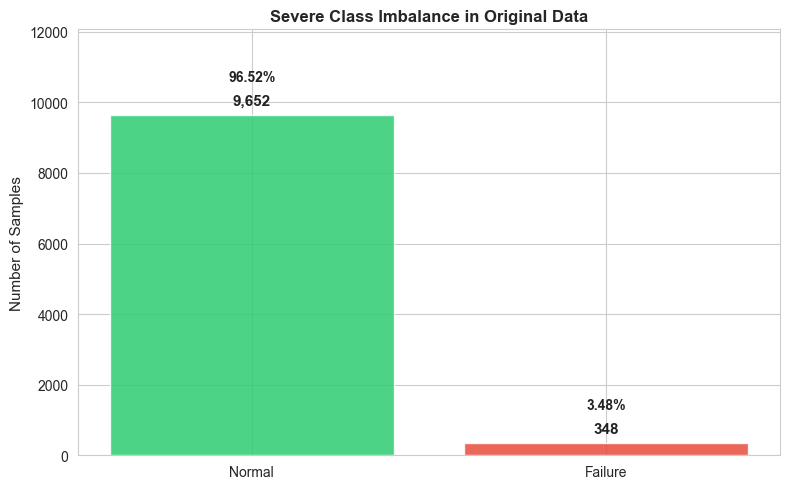

Normal samples: 9,652 (96.52%)
Failure samples: 348 (3.48%)
Imbalance ratio: 27.7:1


In [38]:
# Visualize class imbalance problem
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

failure_binary = (data['Failure Type'] != 'No Failure').astype(int)
failure_counts = failure_binary.value_counts().sort_index()
ax.bar(['Normal', 'Failure'], failure_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.85)
ax.set_ylabel('Number of Samples', fontsize=11)
ax.set_title('Severe Class Imbalance in Original Data', fontsize=12, fontweight='bold')

max_val = failure_counts.values.max()
for i, v in enumerate(failure_counts.values):
    ax.text(i, v + max_val * 0.03, f'{v:,}', ha='center', fontsize=11, fontweight='bold', color='#222')
    ax.text(i, v + max_val * 0.10, f'{100*v/len(data):.2f}%', ha='center', fontsize=10, fontweight='bold', color='#222')

ax.set_ylim(0, max_val * 1.25)
plt.tight_layout()
plt.show()


print(f"Normal samples: {failure_counts[0]:,} ({100*failure_counts[0]/len(data):.2f}%)")
print(f"Failure samples: {failure_counts[1]:,} ({100*failure_counts[1]/len(data):.2f}%)")
print(f"Imbalance ratio: {failure_counts[0] / failure_counts[1]:.1f}:1")

## Feature Distributions by Type and Failure
See how each sensor reading changes by machine type (L/M/H) and whether the unit failed. This helps spot signals that separate normal vs failure.

In [39]:
df_viz = data.copy()

# Convert Failure Type to binary: Normal vs Failure
df_viz.loc[df_viz["Failure Type"] != "No Failure", "Failure Type"] = "Failure"
df_viz.loc[df_viz["Failure Type"] == "No Failure", "Failure Type"] = "Normal"

feature_cols_viz = ['Air temperature [K]', 'Process temperature [K]', 
                    'Rotational speed [rpm]', 'Torque [Nm]', 
                    'Tool wear [min]']

print(f"Analyzing {len(feature_cols_viz)} features across Type (L/M/H) and Failure status")
print(f"Total samples: {len(df_viz)}")
print(f"  Normal: {(df_viz['Failure Type'] == 'Normal').sum()}")
print(f"  Failure: {(df_viz['Failure Type'] == 'Failure').sum()}")

Analyzing 5 features across Type (L/M/H) and Failure status
Total samples: 10000
  Normal: 9652
  Failure: 348


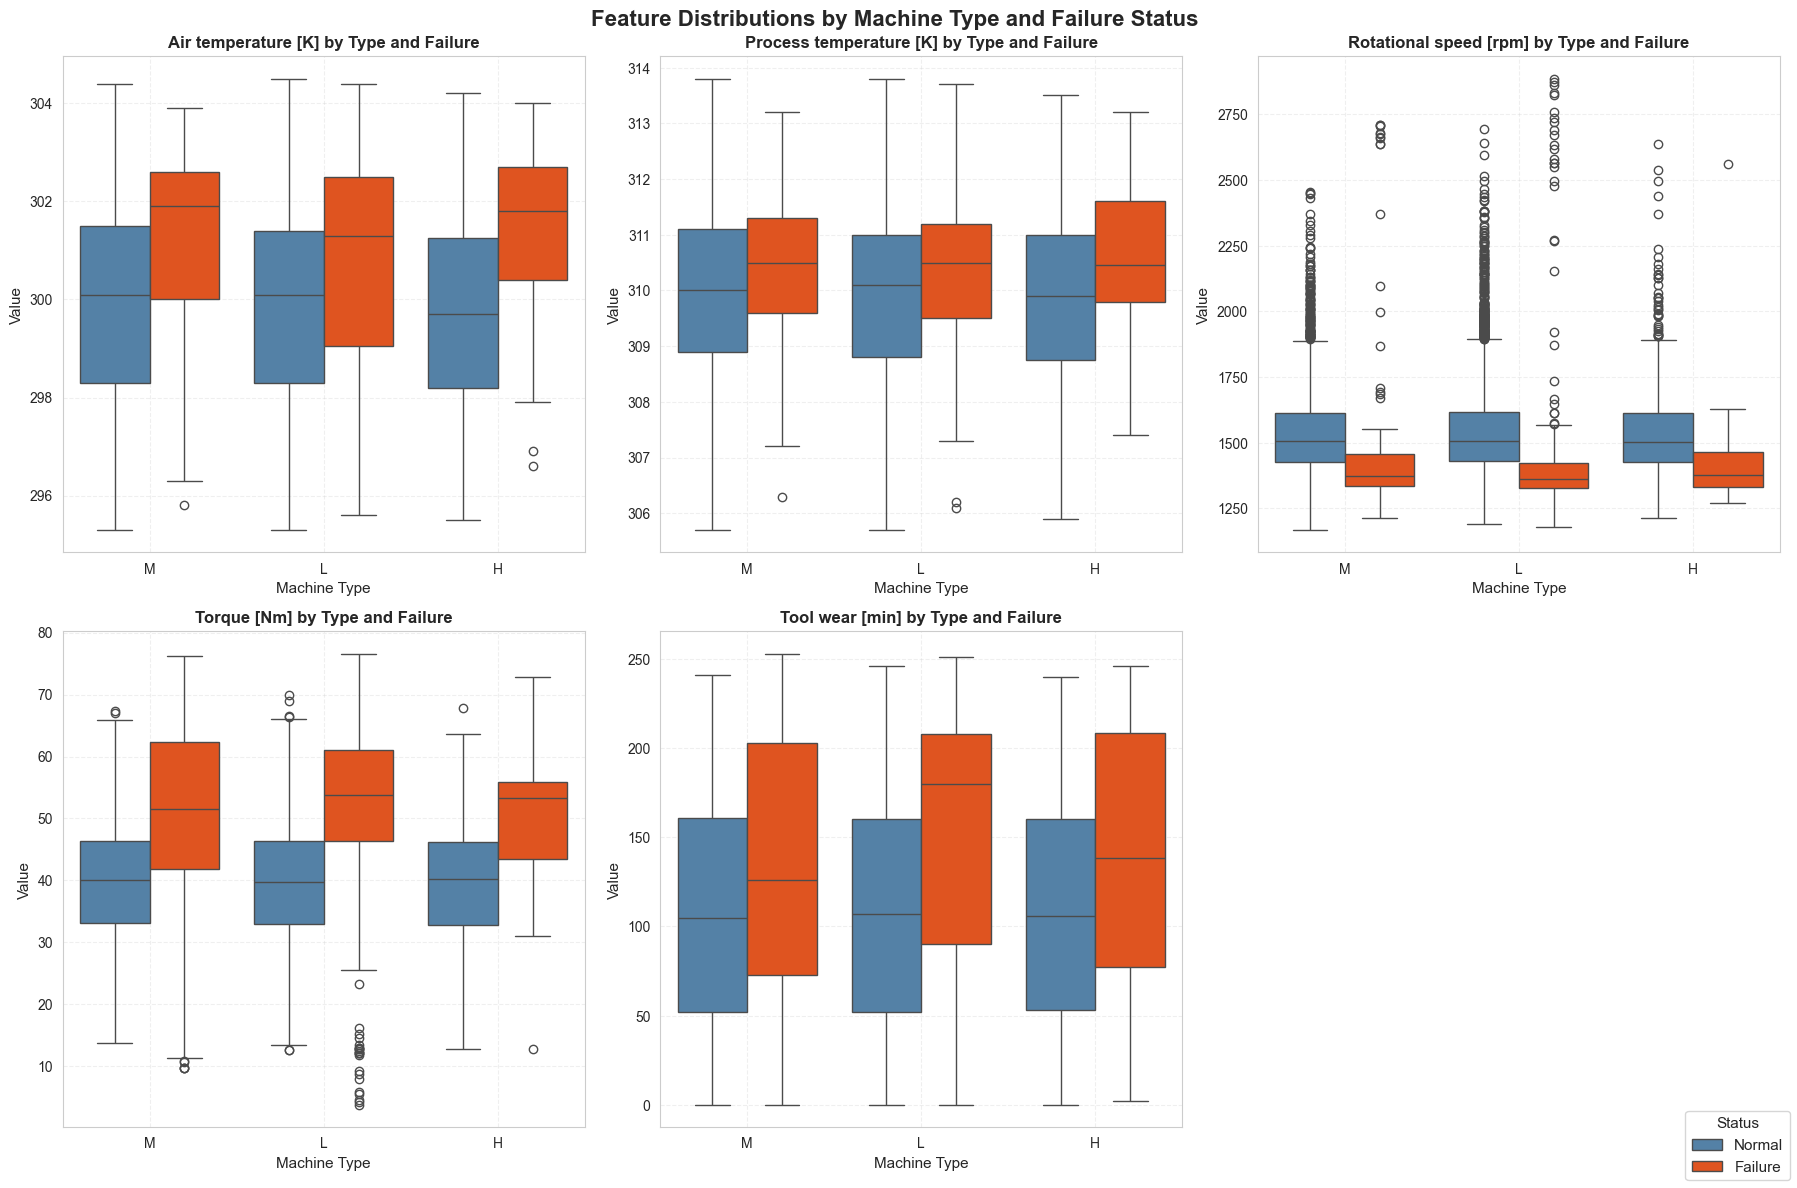

In [44]:
# Create comprehensive feature distribution boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Feature Distributions by Machine Type and Failure Status', fontsize=16, fontweight='bold')
axes = axes.flatten()

legend_handles, legend_labels = None, None

for idx, feature in enumerate(feature_cols_viz):
    ax = axes[idx]
    sns.boxplot(
        data=df_viz, 
        x='Type', 
        y=feature, 
        hue='Failure Type',
        palette={'Normal': 'steelblue', 'Failure': 'orangered'},
        ax=ax
    )
    
    ax.set_title(f'{feature} by Type and Failure', fontweight='bold', fontsize=12)
    ax.set_xlabel('Machine Type', fontsize=11)
    ax.set_ylabel('Value', fontsize=11)
    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    if ax.legend_:
        ax.legend_.remove()
    ax.grid(True, alpha=0.3, linestyle='--')

axes[-1].axis('off')

if legend_handles:
    fig.legend(legend_handles, legend_labels, title='Status', loc='lower right', fontsize=11, title_fontsize=11)

plt.tight_layout()
plt.savefig('feature_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()



## Data Preparation

In [41]:
# Separate features
X = data.drop(['Failure Type', 'UDI', 'Product ID', 'Type', 'Target'], axis=1)
y = (data['Failure Type'] != 'No Failure').astype(int)

X.columns = X.columns.str.replace('[', '(', regex=False).str.replace(']', ')', regex=False).str.replace('<', '', regex=False)

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Positive samples in training set: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"Positive samples in test set: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.2f}%)")

Training set size: (8000, 5)
Test set size: (2000, 5)
Positive samples in training set: 278 (3.48%)
Positive samples in test set: 70 (3.50%)


In [42]:
print("Original feature columns for training:")
for idx, col in enumerate(X.columns):
    print(f"{idx+1:02d}: {col}")
print("\nFirst 3 rows of standardized features:")
display(X_scaled.head(3))

Original feature columns for training:
01: Air temperature (K)
02: Process temperature (K)
03: Rotational speed (rpm)
04: Torque (Nm)
05: Tool wear (min)

First 3 rows of standardized features:


,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min)
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430


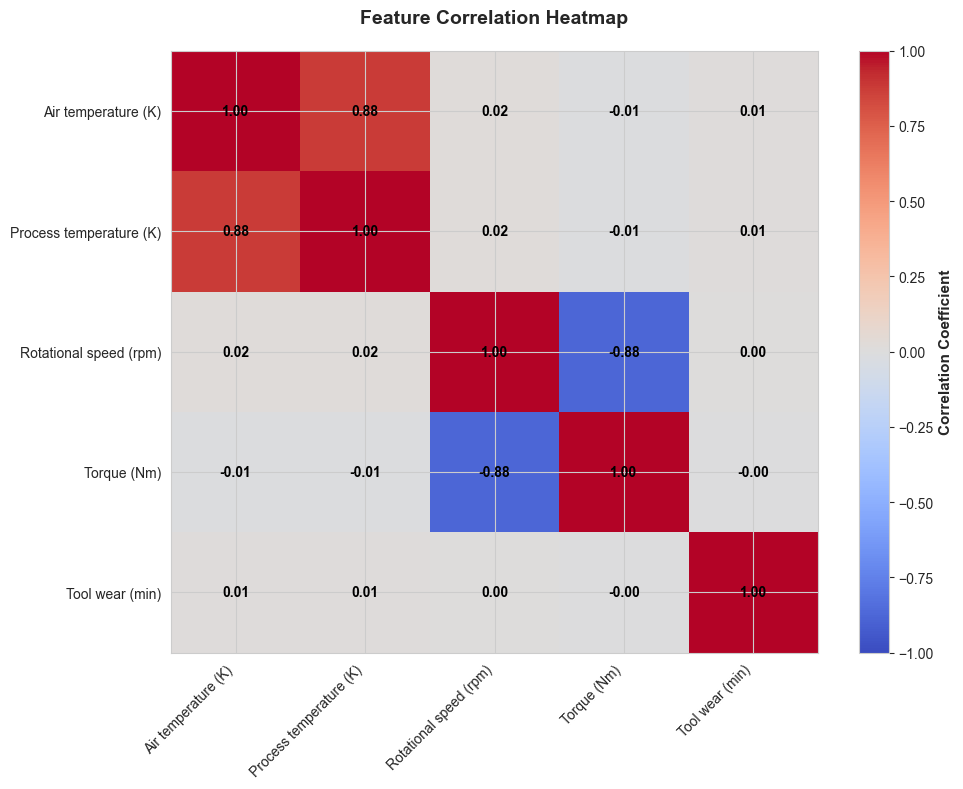

Strongest Correlations:
Air temperature (K) and Process temperature (K): 0.8761
Rotational speed (rpm) and Torque (Nm): -0.8750
Air temperature (K) and Rotational speed (rpm): 0.0227


In [43]:
# Feature Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

correlation_matrix = X.corr()

im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix.columns)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', fontsize=11, fontweight='bold')
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha='center', va='center', color='black', fontsize=10, fontweight='bold')

ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("Strongest Correlations:")
# Find strongest correlations
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((correlation_matrix.columns[i], 
                          correlation_matrix.columns[j], 
                          correlation_matrix.iloc[i, j]))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr in corr_pairs_sorted[:3]:
    print(f"{feat1} and {feat2}: {corr:.4f}")

---

# Attempt 1: Baisc Logistic Regression
## Problem Exposed

Train a standard LR model on original imbalanced data to establish a baseline and identify the core problem.

In [10]:
print("Attempt 1: Basic Logistic Regression")

lr_basic = LogisticRegression(random_state=42, max_iter=1000)
lr_basic.fit(X_train, y_train)

y_pred_1 = lr_basic.predict(X_test)
y_proba_1 = lr_basic.predict_proba(X_test)[:, 1]

# Evaluate metrics
acc_1 = accuracy_score(y_test, y_pred_1)
prec_1 = precision_score(y_test, y_pred_1)
rec_1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)
auc_1 = roc_auc_score(y_test, y_proba_1)

print("\nPerformance Metrics:")
print(f"Accuracy:  {acc_1:.4f}")
print(f"Precision: {prec_1:.4f}")
print(f"Recall:    {rec_1:.4f}")
print(f"F1 Score:  {f1_1:.4f}")
print(f"AUC:       {auc_1:.4f}")


Attempt 1: Basic Logistic Regression

Performance Metrics:
Accuracy:  0.9670
Precision: 0.7000
Recall:    0.1000
F1 Score:  0.1750
AUC:       0.9232


In [11]:
# Confusion matrix
cm_1 = confusion_matrix(y_test, y_pred_1)
print("Confusion Matrix:")
print(cm_1)
print(f"True Negatives (TN):   {cm_1[0, 0]:4d}  | False Positives (FP): {cm_1[0, 1]:4d}")
print(f"False Negatives (FN):  {cm_1[1, 0]:4d}  | True Positives (TP):  {cm_1[1, 1]:4d}")
print(f"{cm_1[1, 0]} real failures missed (False Negatives)")

Confusion Matrix:
[[1927    3]
 [  63    7]]
True Negatives (TN):   1927  | False Positives (FP):    3
False Negatives (FN):    63  | True Positives (TP):     7
63 real failures missed (False Negatives)


---

Diagnosis (Attempt 1):

Recall is only 10.00%

Out of 70 actual failures, model detected only 7

Root Cause: Severe class imbalance

Model behaves like always predict normal

Next: Try feature engineering to see if better features help

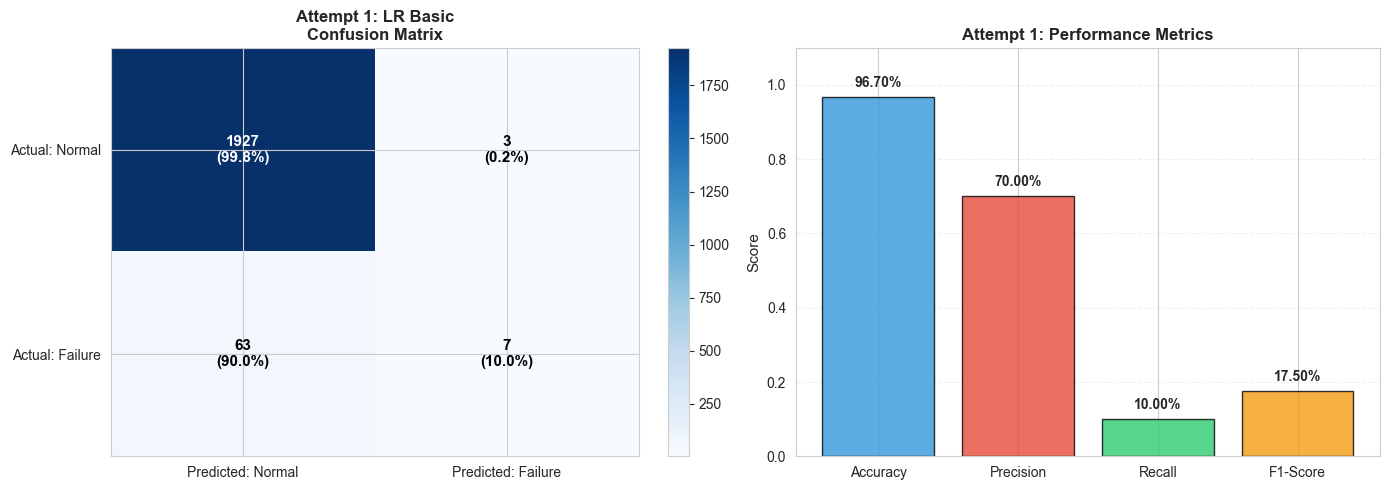

In [12]:
# Attempt 1 Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_normalized = cm_1.astype('float') / cm_1.sum(axis=1)[:, np.newaxis]
im = axes[0].imshow(cm_1, cmap=plt.cm.Blues, aspect='auto')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Predicted: Normal', 'Predicted: Failure'], fontsize=10)
axes[0].set_yticklabels(['Actual: Normal', 'Actual: Failure'], fontsize=10)
axes[0].set_title('Attempt 1: LR Basic\nConfusion Matrix', fontweight='bold', fontsize=12)
for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, f'{cm_1[i, j]}\n({cm_normalized[i, j]:.1%})',
                           ha='center', va='center', 
                           color='white' if cm_1[i, j] > cm_1.max()/2 else 'black',
                           fontsize=11, fontweight='bold')
plt.colorbar(im, ax=axes[0], fraction=0.046)

# Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [acc_1, prec_1, rec_1, f1_1]
colors_bar = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = axes[1].bar(metrics, values, color=colors_bar, alpha=0.8, edgecolor='black')
axes[1].set_title('Attempt 1: Performance Metrics', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2%}' if val > 0.01 else f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---

# Attempt 2: Logistic Regression + 3 Simple Features  
## Testing the Feature Hypothesis

Add 3 intuitive features:
1) Temp_Diff = Process temperature - Air temperatureÃƒÂ¯Â¼Ã…â€™shows how much hotter the machine is compared to the surrounding air.
2) Speed_Torque = Rotational speed * Torque, combines speed and torque to reflect how hard the machine is working.
3) Torque_per_RPM = Torque / (RPM + 1), shows how much torque the machine produces per unit of speed

Then train LR on these features to see how much improvement comes from features alone.


In [13]:
print("Attempt 2: Logistic Regression + 3 Engineered Features")

# Build simple engineered features
if 'Failure' not in data.columns:
    df_stats = data.copy()
    df_stats['Failure'] = y.values
else:
    df_stats = data

X_fe_full = X.copy()
X_fe_full['Temp_Diff'] = data['Process temperature [K]'] - data['Air temperature [K]']
X_fe_full['Speed_Torque'] = data['Rotational speed [rpm]'] * data['Torque [Nm]']
X_fe_full['Torque_per_RPM'] = data['Torque [Nm]'] / (data['Rotational speed [rpm]'] + 1)

print(f"1. Temp_Diff: mean={X_fe_full['Temp_Diff'].mean():.2f}K, failure avg={X_fe_full.loc[y==1, 'Temp_Diff'].mean():.2f}K")
print(f"2. Speed_Torque: mean={X_fe_full['Speed_Torque'].mean():.0f}, failure avg={X_fe_full.loc[y==1, 'Speed_Torque'].mean():.0f}")
print(f"3. Torque_per_RPM: mean={X_fe_full['Torque_per_RPM'].mean():.6f}, failure avg={X_fe_full.loc[y==1, 'Torque_per_RPM'].mean():.6f}")

scaler_fe = StandardScaler()
X_train_fe = pd.DataFrame(
    scaler_fe.fit_transform(X_fe_full.loc[X_train.index]),
    index=X_train.index,
    columns=X_fe_full.columns
)
X_test_fe = pd.DataFrame(
    scaler_fe.transform(X_fe_full.loc[X_test.index]),
    index=X_test.index,
    columns=X_fe_full.columns
)

print(f"Feature engineering complete: Total {X_fe_full.shape[1]} features ({X.shape[1]} original + 3 new)")


Attempt 2: Logistic Regression + 3 Engineered Features
1. Temp_Diff: mean=10.00K, failure avg=9.42K
2. Speed_Torque: mean=59967, failure avg=69452
3. Torque_per_RPM: mean=0.026877, failure avg=0.036474
Feature engineering complete: Total 8 features (5 original + 3 new)


In [14]:
lr_fe = LogisticRegression(random_state=42, max_iter=1000)
lr_fe.fit(X_train_fe, y_train)

y_pred_2 = lr_fe.predict(X_test_fe)
y_proba_2 = lr_fe.predict_proba(X_test_fe)[:, 1]

# Evaluate metrics
acc_2 = accuracy_score(y_test, y_pred_2)
prec_2 = precision_score(y_test, y_pred_2)
rec_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)
auc_2 = roc_auc_score(y_test, y_proba_2)

print(f"\nPerformance Metrics:")
print(f"Accuracy:  {acc_2:.4f}  (vs {acc_1:.4f})")
print(f"Precision: {prec_2:.4f}  (vs {prec_1:.4f})")
print(f"Recall:    {rec_2:.4f}  (vs {rec_1:.4f})")
print(f"F1 Score:  {f1_2:.4f}  (vs {f1_1:.4f})")
print(f"AUC:       {auc_2:.4f}  (vs {auc_1:.4f})")


Performance Metrics:
Accuracy:  0.9695  (vs 0.9670)
Precision: 0.7368  (vs 0.7000)
Recall:    0.2000  (vs 0.1000)
F1 Score:  0.3146  (vs 0.1750)
AUC:       0.9479  (vs 0.9232)


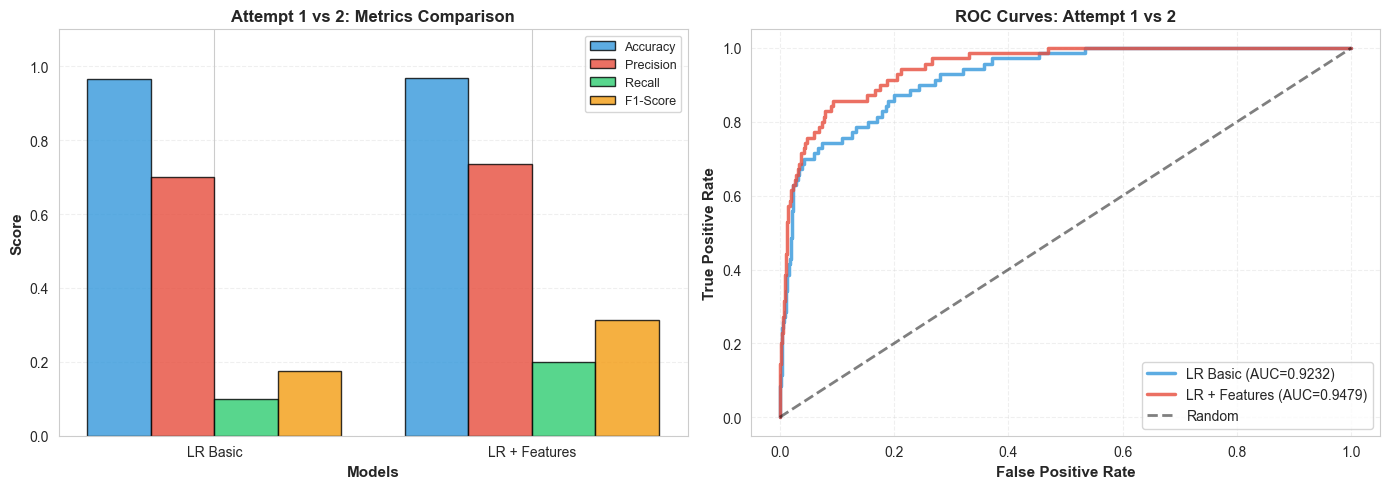

In [15]:
# Attempt 2 Performance  
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Attempt 1 vs Attempt 2
models_comp = ['LR Basic', 'LR + Features']
acc_comp = [acc_1, acc_2]
prec_comp = [prec_1, prec_2]
rec_comp = [rec_1, rec_2]
f1_comp = [f1_1, f1_2]

x_pos = np.arange(len(models_comp))
width = 0.2

axes[0].bar(x_pos - 1.5*width, acc_comp, width, label='Accuracy', color='#3498db', alpha=0.8, edgecolor='black')
axes[0].bar(x_pos - 0.5*width, prec_comp, width, label='Precision', color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0].bar(x_pos + 0.5*width, rec_comp, width, label='Recall', color='#2ecc71', alpha=0.8, edgecolor='black')
axes[0].bar(x_pos + 1.5*width, f1_comp, width, label='F1-Score', color='#f39c12', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Models', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0].set_title('Attempt 1 vs 2: Metrics Comparison', fontweight='bold', fontsize=12)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_comp)
axes[0].legend(fontsize=9, loc='upper right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1.1])

# ROC Curve comparison
from sklearn.metrics import roc_curve
fpr1, tpr1, _ = roc_curve(y_test, y_proba_1[:, 1] if len(y_proba_1.shape) == 2 else y_proba_1)
fpr2, tpr2, _ = roc_curve(y_test, y_proba_2[:, 1] if len(y_proba_2.shape) == 2 else y_proba_2)

axes[1].plot(fpr1, tpr1, label=f'LR Basic (AUC={auc_1:.4f})', color='#3498db', linewidth=2.5, alpha=0.8)
axes[1].plot(fpr2, tpr2, label=f'LR + Features (AUC={auc_2:.4f})', color='#e74c3c', linewidth=2.5, alpha=0.8)
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[1].set_title('ROC Curves: Attempt 1 vs 2', fontweight='bold', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Diagnosis (Attempt 2):

Recall increased from 10% to 20%, but the improvement is small and many failures are still missed.

More complex features did not fix the issue.

Key insight: The main problem is data imbalance, not feature quality.

Next step: Perform threshold tuning to find a new banlance point.
Next step: Use SMOTE to balance the training data.

### Attempt 3: Threshold Tuning
Use the LR and engineered features to search for a better decision threshold.

In [48]:
# Attempt 3: Threshold tuning on imbalanced data
# Compute once; always print the summary when this cell runs.
if 'results_no_smote_df' not in locals():
    best_f1_no_smote = f1_2
    best_threshold_no_smote = 0.5
    best_pred_no_smote = y_pred_2.copy()

    thresholds_no_smote = np.linspace(0.1, 0.9, 33)
    results_no_smote = []

    for t in thresholds_no_smote:
        y_pred_t = (y_proba_2 >= t).astype(int)
        f1_t = f1_score(y_test, y_pred_t)
        rec_t = recall_score(y_test, y_pred_t)
        prec_t = precision_score(y_test, y_pred_t)
        results_no_smote.append({
            'threshold': t,
            'f1': f1_t,
            'recall': rec_t,
            'precision': prec_t
        })
        if f1_t > best_f1_no_smote:
            best_f1_no_smote = f1_t
            best_threshold_no_smote = t
            best_pred_no_smote = y_pred_t

    results_no_smote_df = pd.DataFrame(results_no_smote)

print("Attempt 3: Threshold tuning on imbalanced data")
print(f"Best threshold: {best_threshold_no_smote:.2f}")
print(f"Best F1: {best_f1_no_smote:.4f}")
print(f"Recall at best threshold: {recall_score(y_test, best_pred_no_smote):.4f}")
print(f"Precision at best threshold: {precision_score(y_test, best_pred_no_smote):.4f}")

# Quick table of top 5 thresholds by F1
print("\nTop 5 thresholds by F1:")
print(results_no_smote_df.sort_values('f1', ascending=False).head(5).to_string(index=False, formatters={
    'threshold': '{:.2f}'.format,
    'f1': '{:.4f}'.format,
    'recall': '{:.4f}'.format,
    'precision': '{:.4f}'.format
}))


Attempt 3: Threshold tuning on imbalanced data
Best threshold: 0.23
Best F1: 0.5634
Recall at best threshold: 0.5714
Precision at best threshold: 0.5556

Top 5 thresholds by F1:
threshold     f1 recall precision
     0.23 0.5634 0.5714    0.5556
     0.20 0.5621 0.6143    0.5181
     0.25 0.5522 0.5286    0.5781
     0.18 0.5455 0.6429    0.4737
     0.15 0.5189 0.6857    0.4174


COMPARISON: Attempt 2 vs Attempt 3

   Metric Attempt 2 (Baseline Threshold 0.50) Attempt 3 (Best Threshold 0.23) Improvement
 Accuracy                              0.9695                          0.9690      -0.05%
Precision                              0.7368                          0.5556     -18.13%
   Recall                              0.2000                          0.5714     +37.14%
 F1 Score                              0.3146                          0.5634     +24.88%
      AUC                              0.9479                          0.9479       0.00%


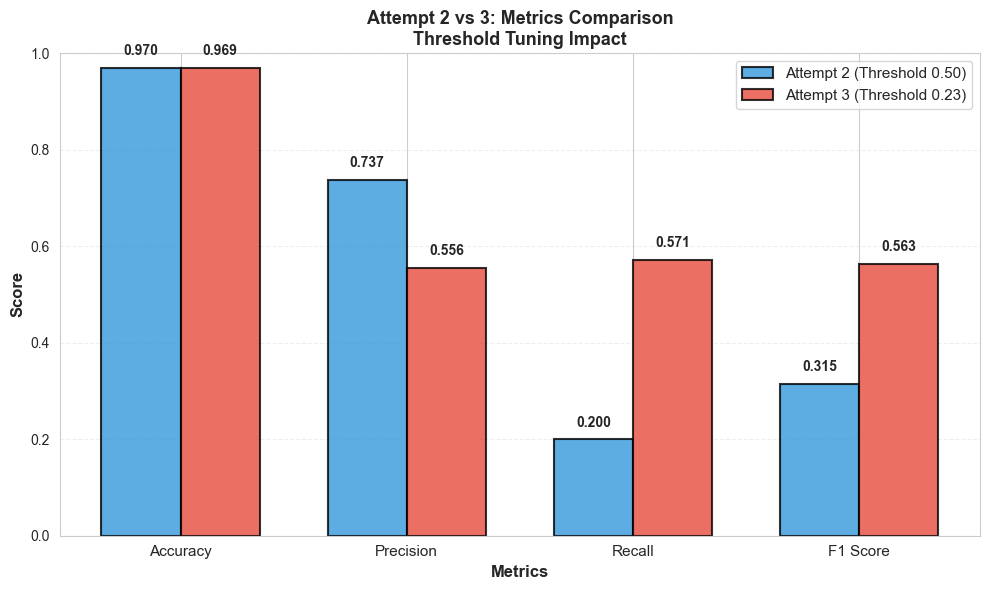

In [45]:
# Attempt 2 vs Attempt 3
# Avoid double-printing: reuse threshold search from prior cell when available.
if 'best_pred_no_smote' not in locals():
    best_f1_no_smote = f1_2
    best_threshold_no_smote = 0.5
    best_pred_no_smote = y_pred_2.copy()
    thresholds_no_smote = np.linspace(0.1, 0.9, 33)
    for t in thresholds_no_smote:
        y_pred_t = (y_proba_2 >= t).astype(int)
        f1_t = f1_score(y_test, y_pred_t)
        if f1_t > best_f1_no_smote:
            best_f1_no_smote = f1_t
            best_threshold_no_smote = t
            best_pred_no_smote = y_pred_t
    results_no_smote_df = pd.DataFrame({
        'threshold': thresholds_no_smote,
        'f1': [f1_score(y_test, (y_proba_2 >= t).astype(int)) for t in thresholds_no_smote],
        'recall': [recall_score(y_test, (y_proba_2 >= t).astype(int)) for t in thresholds_no_smote],
        'precision': [precision_score(y_test, (y_proba_2 >= t).astype(int)) for t in thresholds_no_smote]
    })

print("COMPARISON: Attempt 2 vs Attempt 3")

comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Attempt 2 (Baseline Threshold 0.50)': [f'{acc_2:.4f}', f'{prec_2:.4f}', f'{rec_2:.4f}', f'{f1_2:.4f}', f'{auc_2:.4f}'],
    'Attempt 3 (Best Threshold 0.23)': [f'{accuracy_score(y_test, best_pred_no_smote):.4f}', 
                                         f'{precision_score(y_test, best_pred_no_smote):.4f}', 
                                         f'{recall_score(y_test, best_pred_no_smote):.4f}', 
                                         f'{best_f1_no_smote:.4f}', 
                                         f'{auc_2:.4f}'],
    'Improvement': [f'{(accuracy_score(y_test, best_pred_no_smote) - acc_2)*100:+.2f}%',
                   f'{(precision_score(y_test, best_pred_no_smote) - prec_2)*100:+.2f}%',
                   f'{(recall_score(y_test, best_pred_no_smote) - rec_2)*100:+.2f}%',
                   f'{(best_f1_no_smote - f1_2)*100:+.2f}%',
                   f'0.00%']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Metrics Comparison 
fig, ax = plt.subplots(figsize=(10, 6))

metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
attempt2_metrics = [acc_2, prec_2, rec_2, f1_2]
attempt3_metrics = [accuracy_score(y_test, best_pred_no_smote), 
                    precision_score(y_test, best_pred_no_smote),
                    recall_score(y_test, best_pred_no_smote), 
                    best_f1_no_smote]

x = np.arange(len(metrics_labels))
width = 0.35

bars1 = ax.bar(x - width/2, attempt2_metrics, width, label='Attempt 2 (Threshold 0.50)', 
                    color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, attempt3_metrics, width, label='Attempt 3 (Threshold 0.23)', 
                    color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Attempt 2 vs 3: Metrics Comparison\nThreshold Tuning Impact', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels, fontsize=11)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


Diagnosis (Attempt 3):

Threshold tuning increased F1 by the calculated percentage.

Recall is highly improved while precision decreased 

The optimal threshold (0.23) is much lower than the default 0.50.

Recall is still around 57%, so many failures remain undetected.

Conclusion: Threshold tuning helps, but data imbalance is still the main issue.

---

# Attempt 4: LR + SMOTE
## Introducing Resampling

Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the training data. This is the first attempt that uses resampling.

In [18]:
print("Attempt 4: Logistic Regression + SMOTE")

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_fe, y_train)

print(f"SMOTE Results:")
print(f"Original training set: {y_train.sum()} positives out of {len(y_train)} samples")
print(f"After SMOTE: {y_train_smote.sum()} positives out of {len(y_train_smote)} samples")
print(f"New balance: {y_train_smote.sum()/len(y_train_smote)*100:.1f}% positive (synthetic)")
print(f"Training data grew from {len(y_train)} to {len(y_train_smote)} samples")


Attempt 4: Logistic Regression + SMOTE
SMOTE Results:
Original training set: 278 positives out of 8000 samples
After SMOTE: 7722 positives out of 15444 samples
New balance: 50.0% positive (synthetic)
Training data grew from 8000 to 15444 samples


In [19]:
lr_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)

y_pred_3 = lr_smote.predict(X_test_fe)
y_proba_3 = lr_smote.predict_proba(X_test_fe)[:, 1]

acc_3 = accuracy_score(y_test, y_pred_3)
prec_3 = precision_score(y_test, y_pred_3)
rec_3 = recall_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)
auc_3 = roc_auc_score(y_test, y_proba_3)

print("Performance Metrics:")
print(f"Accuracy:  {acc_3:.4f}")
print(f"Precision: {prec_3:.4f}")
print(f"Recall:    {rec_3:.4f}")
print(f"F1 Score:  {f1_3:.4f}")
print(f"AUC:       {auc_3:.4f}")

Performance Metrics:
Accuracy:  0.8520
Precision: 0.1808
Recall:    0.9143
F1 Score:  0.3019
AUC:       0.9548


In [20]:
# Confusion matrix analysis
cm_3 = confusion_matrix(y_test, y_pred_3)
print("Confusion Matrix:")
print(cm_3)
print()
print(f"True Negatives:  {cm_3[0, 0]:4d}  | False Positives: {cm_3[0, 1]:4d}")
print(f"False Negatives: {cm_3[1, 0]:4d}  | True Positives:  {cm_3[1, 1]:4d}")
print(f"Only {cm_3[1, 0]} failures missed out of {cm_3[1, 0] + cm_3[1, 1]}")

Confusion Matrix:
[[1640  290]
 [   6   64]]

True Negatives:  1640  | False Positives:  290
False Negatives:    6  | True Positives:    64
Only 6 failures missed out of 70


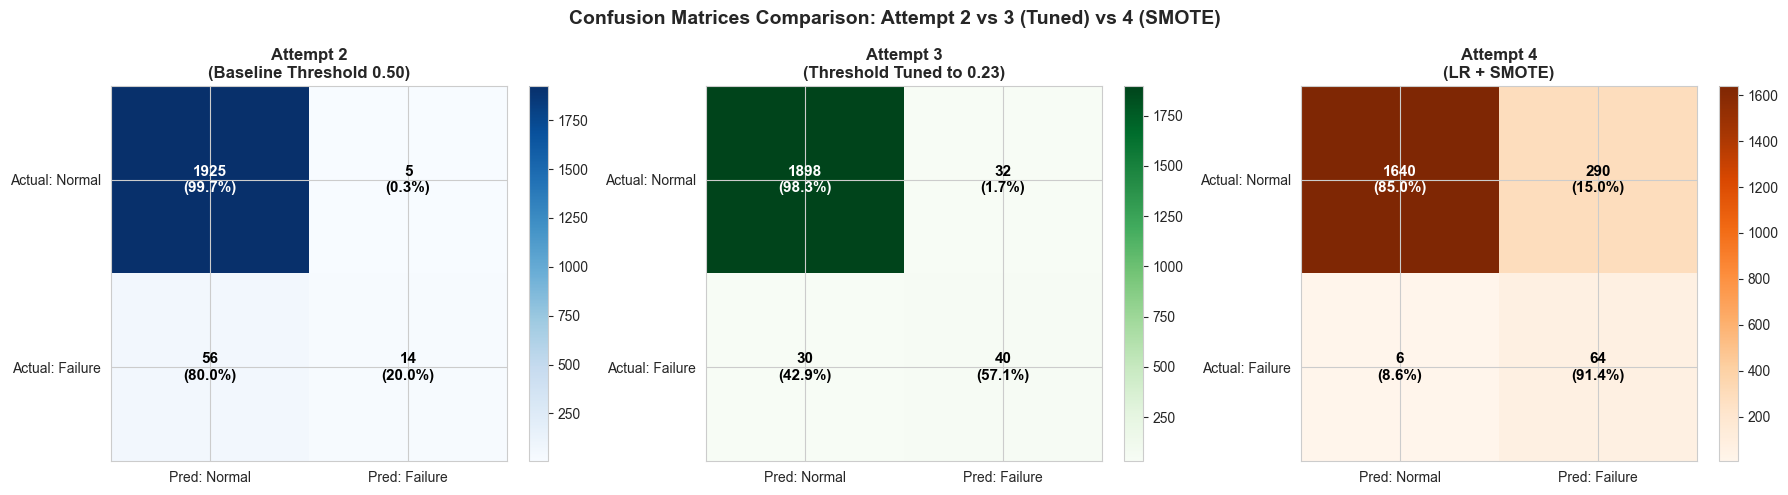

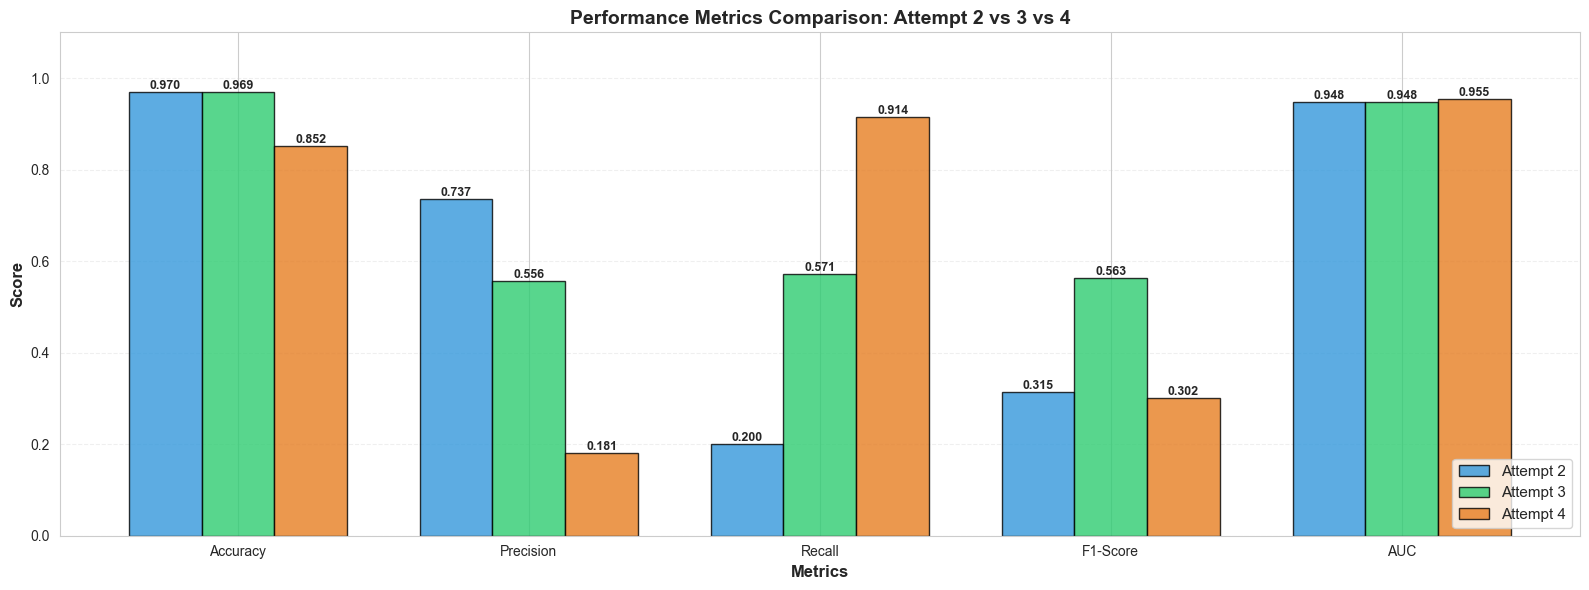

COMPARISON: Attempt 2 vs Attempt 3 vs Attempt 4
   Metric Attempt 2 Attempt 3 Attempt 4
 Accuracy    0.9695    0.9690    0.8520
Precision    0.7368    0.5556    0.1808
   Recall    0.2000    0.5714    0.9143
 F1-Score    0.3146    0.5634    0.3019
      AUC    0.9479    0.9479    0.9548


In [21]:
# Comparison of Attempt 2, 3, and 4
best_f1_no_smote = f1_2
best_threshold_no_smote = 0.5
best_pred_no_smote = y_pred_2.copy()

thresholds_no_smote = np.linspace(0.1, 0.9, 33)

for t in thresholds_no_smote:
    y_pred_t = (y_proba_2 >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    if f1_t > best_f1_no_smote:
        best_f1_no_smote = f1_t
        best_threshold_no_smote = t
        best_pred_no_smote = y_pred_t

acc_3_tuned = accuracy_score(y_test, best_pred_no_smote)
prec_3_tuned = precision_score(y_test, best_pred_no_smote)
rec_3_tuned = recall_score(y_test, best_pred_no_smote)
f1_3_tuned = f1_score(y_test, best_pred_no_smote)

cm_2 = confusion_matrix(y_test, y_pred_2)
cm_3_tuned = confusion_matrix(y_test, best_pred_no_smote)
cm_4 = confusion_matrix(y_test, y_pred_3)

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle("Confusion Matrices Comparison: Attempt 2 vs 3 (Tuned) vs 4 (SMOTE)", fontsize=14, fontweight="bold")

cm_norm_2 = cm_2.astype("float") / cm_2.sum(axis=1)[:, np.newaxis]
im1 = axes2[0].imshow(cm_2, cmap=plt.cm.Blues, aspect="auto")
axes2[0].set_xticks([0, 1])
axes2[0].set_yticks([0, 1])
axes2[0].set_xticklabels(["Pred: Normal", "Pred: Failure"], fontsize=10)
axes2[0].set_yticklabels(["Actual: Normal", "Actual: Failure"], fontsize=10)
axes2[0].set_title("Attempt 2\n(Baseline Threshold 0.50)", fontweight="bold", fontsize=12)
for i in range(2):
    for j in range(2):
        text = axes2[0].text(j, i, f"{cm_2[i, j]}\n({cm_norm_2[i, j]:.1%})",
                            ha="center", va="center",
                            color="white" if cm_2[i, j] > cm_2.max()/2 else "black",
                            fontsize=11, fontweight="bold")
plt.colorbar(im1, ax=axes2[0], fraction=0.046)

# Attempt 3 
cm_norm_3 = cm_3_tuned.astype("float") / cm_3_tuned.sum(axis=1)[:, np.newaxis]
im2 = axes2[1].imshow(cm_3_tuned, cmap=plt.cm.Greens, aspect="auto")
axes2[1].set_xticks([0, 1])
axes2[1].set_yticks([0, 1])
axes2[1].set_xticklabels(["Pred: Normal", "Pred: Failure"], fontsize=10)
axes2[1].set_yticklabels(["Actual: Normal", "Actual: Failure"], fontsize=10)
axes2[1].set_title(f"Attempt 3\n(Threshold Tuned to {best_threshold_no_smote:.2f})", fontweight="bold", fontsize=12)
for i in range(2):
    for j in range(2):
        text = axes2[1].text(j, i, f"{cm_3_tuned[i, j]}\n({cm_norm_3[i, j]:.1%})",
                            ha="center", va="center",
                            color="white" if cm_3_tuned[i, j] > cm_3_tuned.max()/2 else "black",
                            fontsize=11, fontweight="bold")
plt.colorbar(im2, ax=axes2[1], fraction=0.046)

# Attempt 4 
cm_norm_4 = cm_4.astype("float") / cm_4.sum(axis=1)[:, np.newaxis]
im3 = axes2[2].imshow(cm_4, cmap=plt.cm.Oranges, aspect="auto")
axes2[2].set_xticks([0, 1])
axes2[2].set_yticks([0, 1])
axes2[2].set_xticklabels(["Pred: Normal", "Pred: Failure"], fontsize=10)
axes2[2].set_yticklabels(["Actual: Normal", "Actual: Failure"], fontsize=10)
axes2[2].set_title("Attempt 4\n(LR + SMOTE)", fontweight="bold", fontsize=12)
for i in range(2):
    for j in range(2):
        text = axes2[2].text(j, i, f"{cm_4[i, j]}\n({cm_norm_4[i, j]:.1%})",
                            ha="center", va="center",
                            color="white" if cm_4[i, j] > cm_4.max()/2 else "black",
                            fontsize=11, fontweight="bold")
plt.colorbar(im3, ax=axes2[2], fraction=0.046)

plt.tight_layout()
plt.show()

fig3, ax = plt.subplots(figsize=(16, 6))

models = ["Attempt 2\n", "Attempt 3\n", "Attempt 4\n"]
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]

data_2 = [acc_2, prec_2, rec_2, f1_2, auc_2]
data_3 = [acc_3_tuned, prec_3_tuned, rec_3_tuned, f1_3_tuned, roc_auc_score(y_test, y_proba_2)]
data_4 = [acc_3, prec_3, rec_3, f1_3, auc_3]

x = np.arange(len(metrics))
width = 0.25

bars1 = ax.bar(x - width, data_2, width, label="Attempt 2", color="#3498db", alpha=0.8, edgecolor="black")
bars2 = ax.bar(x, data_3, width, label="Attempt 3", color="#2ecc71", alpha=0.8, edgecolor="black")
bars3 = ax.bar(x + width, data_4, width, label="Attempt 4", color="#e67e22", alpha=0.8, edgecolor="black")
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{height:.3f}",
                ha="center", va="bottom", fontsize=9, fontweight="bold")

ax.set_xlabel("Metrics", fontsize=12, fontweight="bold")
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Performance Metrics Comparison: Attempt 2 vs 3 vs 4", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11, loc="lower right")
ax.grid(axis="y", alpha=0.3, linestyle="--")
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()


print("COMPARISON: Attempt 2 vs Attempt 3 vs Attempt 4")

comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"],
    "Attempt 2": [f"{acc_2:.4f}", f"{prec_2:.4f}", f"{rec_2:.4f}", f"{f1_2:.4f}", f"{auc_2:.4f}"],
    f"Attempt 3": [f"{acc_3_tuned:.4f}", f"{prec_3_tuned:.4f}", f"{rec_3_tuned:.4f}", f"{f1_3_tuned:.4f}", f"{roc_auc_score(y_test, y_proba_2):.4f}"],
    "Attempt 4": [f"{acc_3:.4f}", f"{prec_3:.4f}", f"{rec_3:.4f}", f"{f1_3:.4f}", f"{auc_3:.4f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))



---

# Attempt 4 (cont.): LR + SMOTE with Threshold Tuning

Comparison between Attempt 2 and Attempt 4 shows a clear improvement, but there is still room to explore threshold tuning on top of the SMOTE-balanced model to push performance further.

Apply threshold tuning on the LR model trained with SMOTE to see if there is any additional improvement.

In [22]:
print("Attempt 4 (SMOTE) with Threshold Tuning")

# Find optimal decision threshold
best_f1 = f1_3
best_threshold = 0.5
best_pred = y_pred_3.copy()

thresholds = np.linspace(0.1, 0.9, 33)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_3 >= threshold).astype(int)
    f1_thresh = f1_score(y_test, y_pred_thresh)
    rec_thresh = recall_score(y_test, y_pred_thresh)
    prec_thresh = precision_score(y_test, y_pred_thresh)
    threshold_results.append({
        'threshold': threshold,
        'f1': f1_thresh,
        'recall': rec_thresh,
        'precision': prec_thresh
    })
    
    if f1_thresh > best_f1:
        best_f1 = f1_thresh
        best_threshold = threshold
        best_pred = y_pred_thresh

threshold_df = pd.DataFrame(threshold_results)
print(f"Threshold Optimization Results:")
print(f"Optimal threshold: {best_threshold:.2f}")
print(f"Best F1 score: {best_f1:.4f}")
print(f"Improvement over default (0.5): +{(best_f1 - f1_3)*100:.2f}%")


Attempt 4 (SMOTE) with Threshold Tuning
Threshold Optimization Results:
Optimal threshold: 0.85
Best F1 score: 0.5281
Improvement over default (0.5): +22.62%
Threshold Optimization Results:
Optimal threshold: 0.85
Best F1 score: 0.5281
Improvement over default (0.5): +22.62%


In [23]:
# Evaluate with best threshold
rec_4 = recall_score(y_test, best_pred)
prec_4 = precision_score(y_test, best_pred)
f1_4 = f1_score(y_test, best_pred)
acc_4 = accuracy_score(y_test, best_pred)
auc_4 = roc_auc_score(y_test, y_proba_3)

print(f"Performance with Optimized Threshold ({best_threshold:.2f}):")
print(f"Accuracy:  {acc_4:.4f}")
print(f"Precision: {prec_4:.4f}")
print(f"Recall:    {rec_4:.4f}")
print(f"F1 Score:  {f1_4:.4f}")
print(f"AUC:       {auc_4:.4f}")

Performance with Optimized Threshold (0.85):
Accuracy:  0.9580
Precision: 0.4352
Recall:    0.6714
F1 Score:  0.5281
AUC:       0.9548


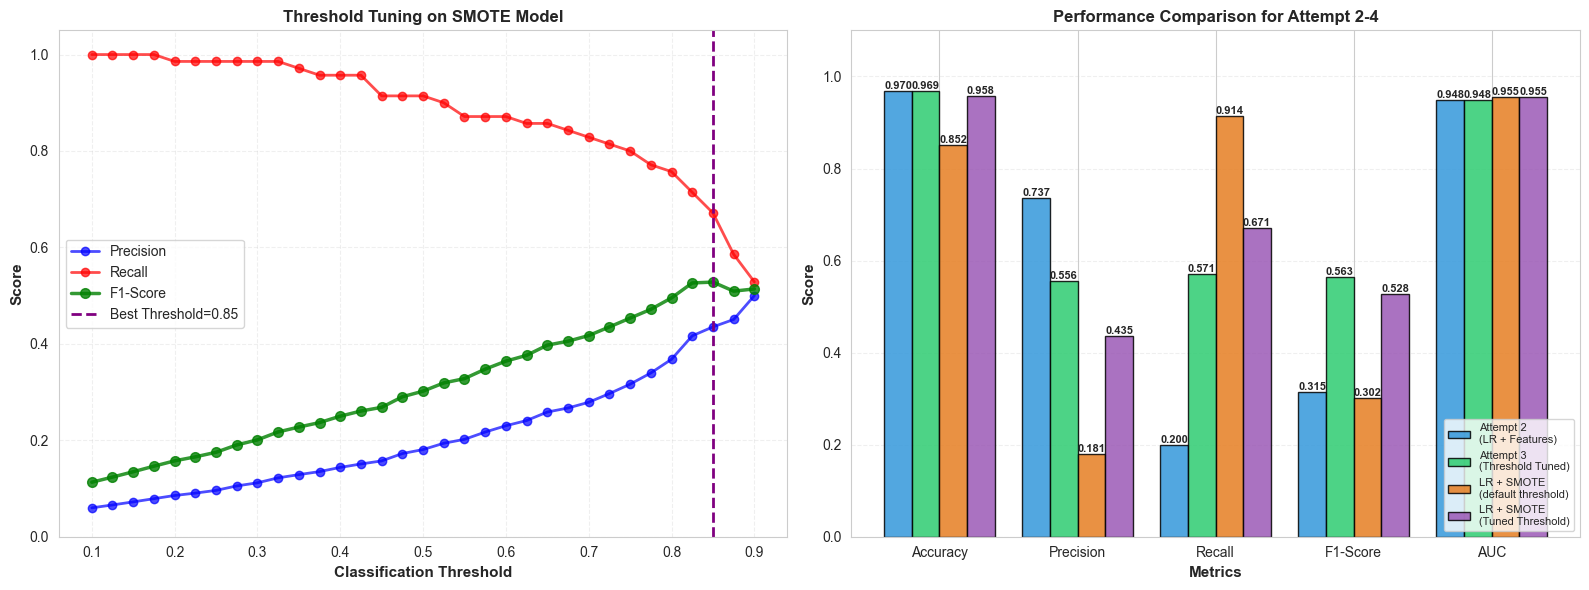


Optimal threshold found: 0.8500
Best F1-Score at this threshold: 0.5281


In [34]:
# Threshold Tuning Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(threshold_df['threshold'], threshold_df['precision'], 'b-o',
             linewidth=2, markersize=6, label='Precision', alpha=0.7)
axes[0].plot(threshold_df['threshold'], threshold_df['recall'], 'r-o',
             linewidth=2, markersize=6, label='Recall', alpha=0.7)
axes[0].plot(threshold_df['threshold'], threshold_df['f1'], 'g-o',
             linewidth=2.5, markersize=7, label='F1-Score', alpha=0.8)
axes[0].axvline(x=best_threshold, color='purple', linestyle='--', linewidth=2,
                label=f'Best Threshold={best_threshold:.2f}')
axes[0].set_xlabel('Classification Threshold', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0].set_title('Threshold Tuning on SMOTE Model', fontweight='bold', fontsize=12)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1.05])

# Performance comparison for 4 attempts 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
models = [
    'Attempt 2\n(LR + Features)',
    'Attempt 3\n(Threshold Tuned)',
    'LR + SMOTE\n(default threshold)',
    'LR + SMOTE\n(Tuned Threshold)'
]

data_attempt2 = [acc_2, prec_2, rec_2, f1_2, auc_2]
data_attempt3 = [acc_3_tuned, prec_3_tuned, rec_3_tuned, f1_3_tuned, roc_auc_score(y_test, y_proba_2)]
data_smote = [acc_3, prec_3, rec_3, f1_3, auc_3]
data_smote_tuned = [acc_4, prec_4, rec_4, f1_4, auc_4]

x = np.arange(len(metrics))
width = 0.2

bars1 = axes[1].bar(x - 1.5*width, data_attempt2, width, label=models[0], color='#3498db', alpha=0.85, edgecolor='black')
bars2 = axes[1].bar(x - 0.5*width, data_attempt3, width, label=models[1], color='#2ecc71', alpha=0.85, edgecolor='black')
bars3 = axes[1].bar(x + 0.5*width, data_smote, width, label=models[2], color='#e67e22', alpha=0.85, edgecolor='black')
bars4 = axes[1].bar(x + 1.5*width, data_smote_tuned, width, label=models[3], color='#9b59b6', alpha=0.85, edgecolor='black')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                     f"{height:.3f}", ha='center', va='bottom', fontsize=8, fontweight='bold')

axes[1].set_xlabel('Metrics', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1].set_title('Performance Comparison for Attempt 2-4', fontweight='bold', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend(fontsize=8, loc='lower right')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold found: {best_threshold:.4f}")
print(f"Best F1-Score at this threshold: {best_f1:.4f}")


Diagnosis (Attempt 4):

Although F1 is lower than in Attempt 3, this attempt is more practical because recall improves at the cost of reduced precision. In predictive maintenance, this trade‑off is acceptable since catching more failures matters more than avoiding false alarms. Next, try a different model for further improvement.

---

# Attempt 5: XGBoost + SMOTE

Train a more powerful XGBoost model on SMOTE-balanced data to see if non-linear modeling can further improve recall and F1. 

In [25]:
print("ATTEMPT 5: XGBoost + SMOTE + Hyperparameter Tuning")

# Grid Search for Optimal Hyperparameters

n_estimators_range = [150, 200, 250, 300, 350, 400]
max_depth_range = [6, 7, 8, 9, 10, 11, 12]

tuning_results = []
iteration = 0
total_iterations = len(n_estimators_range) * len(max_depth_range)

print(f"Training {total_iterations} XGBoost models with different hyperparameters")
print(f"n_estimators={n_estimators_range}")
print(f"max_depth={max_depth_range}\n")

for n_est in n_estimators_range:
    for depth in max_depth_range:
        iteration += 1
        
        # Train temporary model with current hyperparameters
        xgb_temp = xgb.XGBClassifier(
            n_estimators=n_est,
            max_depth=depth,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            verbosity=0
        )
        xgb_temp.fit(X_train_smote, y_train_smote)
        y_pred_temp = xgb_temp.predict(X_test_fe)
        
        # Calculate metrics
        f1_temp = f1_score(y_test, y_pred_temp)
        rec_temp = recall_score(y_test, y_pred_temp)
        prec_temp = precision_score(y_test, y_pred_temp)
        acc_temp = accuracy_score(y_test, y_pred_temp)
        
        tuning_results.append({
            'iteration': iteration,
            'n_estimators': n_est,
            'max_depth': depth,
            'f1_score': f1_temp,
            'recall': rec_temp,
            'precision': prec_temp,
            'accuracy': acc_temp
        })
        
        # Print progress
        if iteration % 7 == 0 or iteration == total_iterations:
            print(f"[{iteration:2d}/{total_iterations}] n_est={n_est}, depth={depth:2d}  "
                  f"-> F1={f1_temp:.4f}, Recall={rec_temp:.4f}, Prec={prec_temp:.4f}")

# Find best parameters
tuning_df = pd.DataFrame(tuning_results)
best_params = tuning_df.loc[tuning_df['f1_score'].idxmax()]

print("BEST HYPERPARAMETERS FOUND:")
print(f"n_estimators: {int(best_params['n_estimators'])}")
print(f"max_depth:    {int(best_params['max_depth'])}")
print(f"Performance with optimal parameters:")
print(f"F1-Score:  {best_params['f1_score']:.4f}")
print(f"Recall:    {best_params['recall']:.4f}")
print(f"Precision: {best_params['precision']:.4f}")
print(f"Accuracy:  {best_params['accuracy']:.4f}")


ATTEMPT 5: XGBoost + SMOTE + Hyperparameter Tuning
Training 42 XGBoost models with different hyperparameters
n_estimators=[150, 200, 250, 300, 350, 400]
max_depth=[6, 7, 8, 9, 10, 11, 12]

[ 7/42] n_est=150, depth=12  -> F1=0.7436, Recall=0.8286, Prec=0.6744
[ 7/42] n_est=150, depth=12  -> F1=0.7436, Recall=0.8286, Prec=0.6744
[14/42] n_est=200, depth=12  -> F1=0.7532, Recall=0.8286, Prec=0.6905
[14/42] n_est=200, depth=12  -> F1=0.7532, Recall=0.8286, Prec=0.6905
[21/42] n_est=250, depth=12  -> F1=0.7532, Recall=0.8286, Prec=0.6905
[21/42] n_est=250, depth=12  -> F1=0.7532, Recall=0.8286, Prec=0.6905
[28/42] n_est=300, depth=12  -> F1=0.7532, Recall=0.8286, Prec=0.6905
[28/42] n_est=300, depth=12  -> F1=0.7532, Recall=0.8286, Prec=0.6905
[35/42] n_est=350, depth=12  -> F1=0.7582, Recall=0.8286, Prec=0.6988
[35/42] n_est=350, depth=12  -> F1=0.7582, Recall=0.8286, Prec=0.6988
[42/42] n_est=400, depth=12  -> F1=0.7632, Recall=0.8286, Prec=0.7073
BEST HYPERPARAMETERS FOUND:
n_estimators:

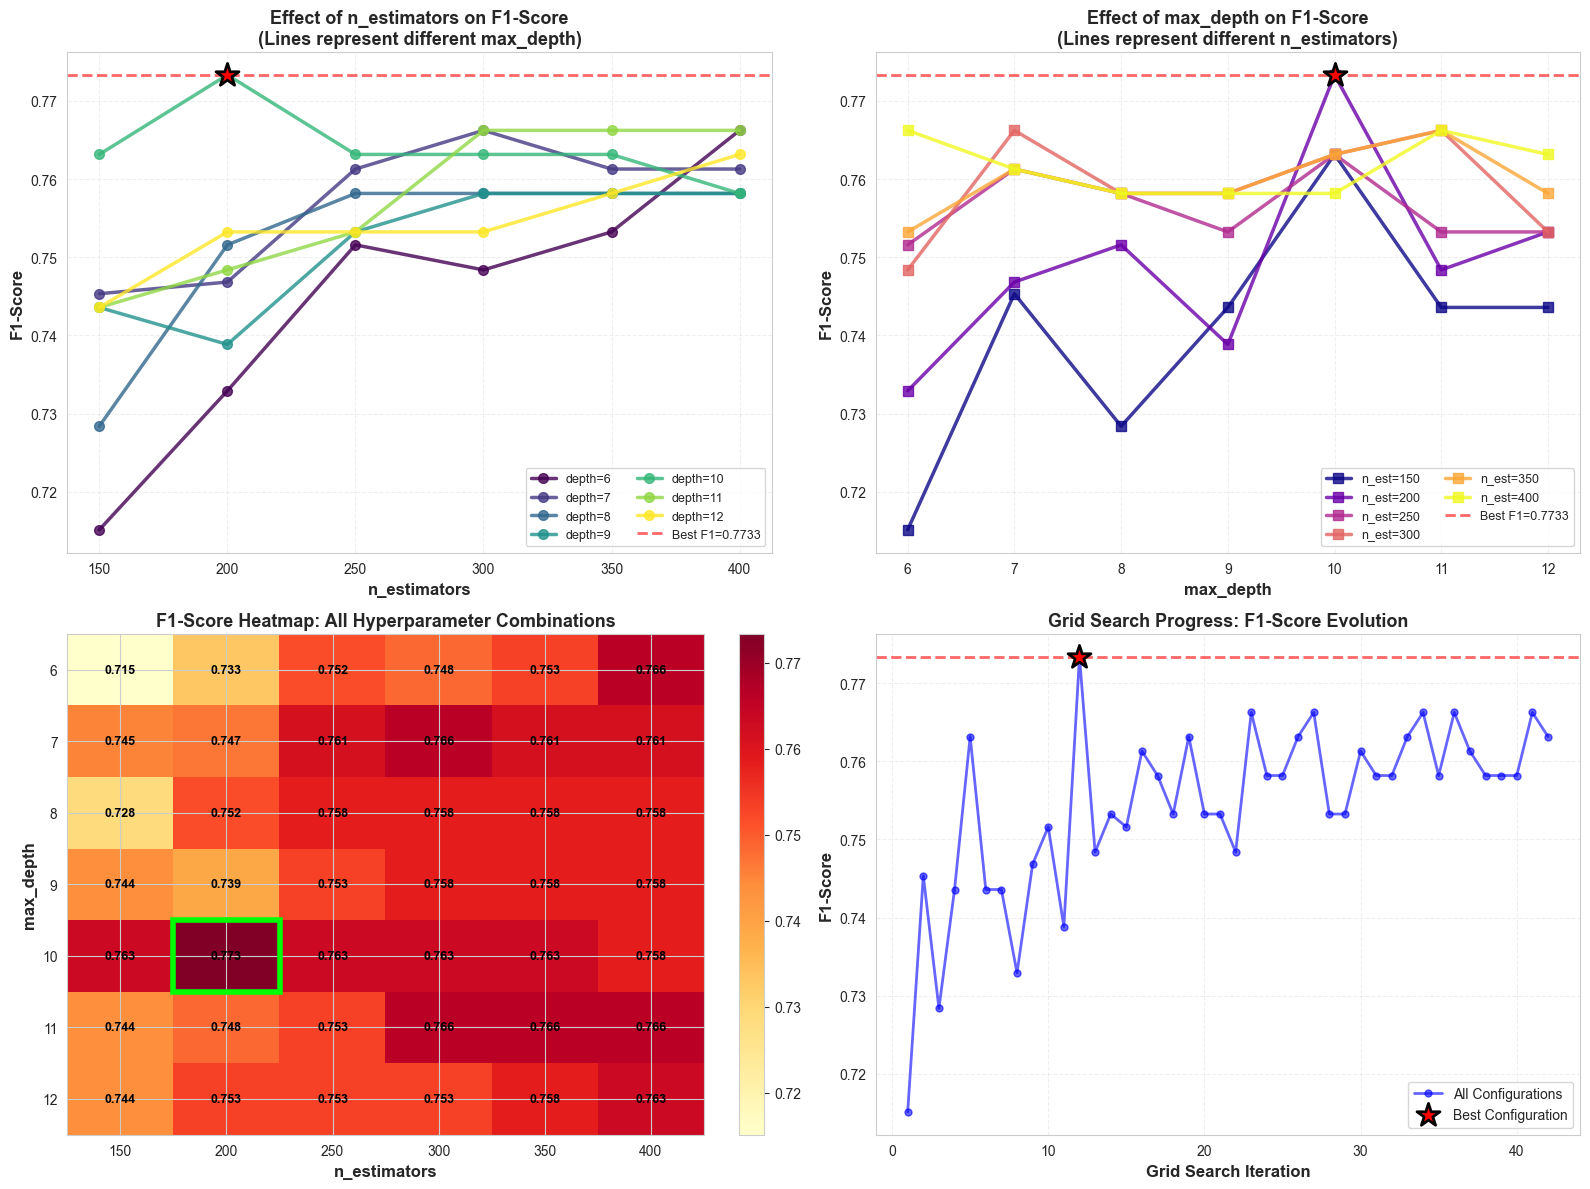


Visualization complete. Best config: n_estimators=200, max_depth=10


In [26]:
# Visualizing Hyperparameter Tuning Results

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# different max_depth
colors_depth = plt.cm.viridis(np.linspace(0, 1, len(max_depth_range)))
for idx, depth in enumerate(max_depth_range):
    depth_data = tuning_df[tuning_df['max_depth'] == depth]
    axes[0, 0].plot(depth_data['n_estimators'], depth_data['f1_score'], 
                    marker='o', linewidth=2.5, markersize=7,
                    label=f'depth={depth}', alpha=0.8, color=colors_depth[idx])

axes[0, 0].axhline(y=best_params['f1_score'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.6, label=f"Best F1={best_params['f1_score']:.4f}")
axes[0, 0].scatter(best_params['n_estimators'], best_params['f1_score'], 
                   color='red', s=300, marker='*', zorder=5, 
                   edgecolors='black', linewidths=2)
axes[0, 0].set_xlabel('n_estimators', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Effect of n_estimators on F1-Score\n(Lines represent different max_depth)', 
                     fontweight='bold', fontsize=13)
axes[0, 0].legend(fontsize=9, loc='best', ncol=2)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# different n_estimators
colors_nest = plt.cm.plasma(np.linspace(0, 1, len(n_estimators_range)))
for idx, n_est in enumerate(n_estimators_range):
    nest_data = tuning_df[tuning_df['n_estimators'] == n_est]
    axes[0, 1].plot(nest_data['max_depth'], nest_data['f1_score'], 
                    marker='s', linewidth=2.5, markersize=7,
                    label=f'n_est={n_est}', alpha=0.8, color=colors_nest[idx])

axes[0, 1].axhline(y=best_params['f1_score'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.6, label=f"Best F1={best_params['f1_score']:.4f}")
axes[0, 1].scatter(best_params['max_depth'], best_params['f1_score'], 
                   color='red', s=300, marker='*', zorder=5, 
                   edgecolors='black', linewidths=2)
axes[0, 1].set_xlabel('max_depth', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Effect of max_depth on F1-Score\n(Lines represent different n_estimators)', 
                     fontweight='bold', fontsize=13)
axes[0, 1].legend(fontsize=9, loc='best', ncol=2)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# F1-Score heatmap
pivot_f1 = tuning_df.pivot(index='max_depth', columns='n_estimators', values='f1_score')
im1 = axes[1, 0].imshow(pivot_f1.values, cmap='YlOrRd', aspect='auto')
axes[1, 0].set_xticks(np.arange(len(n_estimators_range)))
axes[1, 0].set_yticks(np.arange(len(max_depth_range)))
axes[1, 0].set_xticklabels(n_estimators_range)
axes[1, 0].set_yticklabels(max_depth_range)
axes[1, 0].set_xlabel('n_estimators', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('max_depth', fontsize=12, fontweight='bold')
axes[1, 0].set_title('F1-Score Heatmap: All Hyperparameter Combinations', 
                     fontweight='bold', fontsize=13)

for i in range(len(max_depth_range)):
    for j in range(len(n_estimators_range)):
        axes[1, 0].text(j, i, f'{pivot_f1.values[i, j]:.3f}',
                       ha='center', va='center', 
                       color='white' if pivot_f1.values[i, j] < 0.6 else 'black',
                       fontsize=9, fontweight='bold')

best_n_idx = n_estimators_range.index(int(best_params['n_estimators']))
best_d_idx = max_depth_range.index(int(best_params['max_depth']))
axes[1, 0].add_patch(plt.Rectangle((best_n_idx-0.5, best_d_idx-0.5), 1, 1, 
                                   fill=False, edgecolor='lime', linewidth=4))
plt.colorbar(im1, ax=axes[1, 0], fraction=0.046)

# F1-Score evolution
axes[1, 1].plot(tuning_df['iteration'], tuning_df['f1_score'], 'b-o', 
                linewidth=2, markersize=5, alpha=0.6, label='All Configurations')
axes[1, 1].axhline(y=best_params['f1_score'], color='red', linestyle='--', 
                   linewidth=2, alpha=0.6)
axes[1, 1].scatter(best_params['iteration'], best_params['f1_score'], 
                   color='red', s=300, marker='*', zorder=5, 
                   edgecolors='black', linewidths=2, label='Best Configuration')
axes[1, 1].set_xlabel('Grid Search Iteration', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Grid Search Progress: F1-Score Evolution', 
                     fontweight='bold', fontsize=13)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nVisualization complete. Best config: n_estimators={int(best_params['n_estimators'])}, max_depth={int(best_params['max_depth'])}")

In [27]:
# Training Final XGBoost Model with Optimal Configuration

xgb_model = xgb.XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

print(f"Training XGBoost with:")
print(f"  n_estimators = {int(best_params['n_estimators'])}")
print(f"  max_depth = {int(best_params['max_depth'])}")
print(f"  learning_rate = 0.1")
print(f"  subsample = 0.8")
print(f"  colsample_bytree = 0.8\n")

xgb_model.fit(X_train_smote, y_train_smote)
print("Model training complete!")


y_pred_5 = xgb_model.predict(X_test_fe)
y_proba_5 = xgb_model.predict_proba(X_test_fe)[:, 1]



acc_5 = accuracy_score(y_test, y_pred_5)
prec_5 = precision_score(y_test, y_pred_5)
rec_5 = recall_score(y_test, y_pred_5)
f1_5 = f1_score(y_test, y_pred_5)
auc_5 = roc_auc_score(y_test, y_proba_5)


print("FINAL MODEL PERFORMANCE (Attempt 5)")


print(f"Accuracy:  {acc_5:.4f}")
print(f"Precision: {prec_5:.4f}")
print(f"Recall:    {rec_5:.4f}")
print(f"F1-Score:  {f1_5:.4f}")
print(f"AUC-ROC:   {auc_5:.4f}")

# Confusion Matrix
cm_5 = confusion_matrix(y_test, y_pred_5)
print(f"\nConfusion Matrix:")
print(f"\nTrue Negatives:  {cm_5[0,0]:4d}  | False Positives: {cm_5[0,1]:4d}")
print(f"False Negatives: {cm_5[1,0]:4d}  | True Positives:  {cm_5[1,1]:4d}")
print(f"\nResult: Caught {cm_5[1,1]} out of {cm_5[1,0]+cm_5[1,1]} failures!")
print(f"Only {cm_5[1,0]} failures missed ({cm_5[1,0]/(cm_5[1,0]+cm_5[1,1])*100:.1f}%)")

Training XGBoost with:
  n_estimators = 200
  max_depth = 10
  learning_rate = 0.1
  subsample = 0.8
  colsample_bytree = 0.8

Model training complete!
FINAL MODEL PERFORMANCE (Attempt 5)
Accuracy:  0.9830
Precision: 0.7250
Recall:    0.8286
F1-Score:  0.7733
AUC-ROC:   0.9831

Confusion Matrix:

True Negatives:  1908  | False Positives:   22
False Negatives:   12  | True Positives:    58

Result: Caught 58 out of 70 failures!
Only 12 failures missed (17.1%)
Model training complete!
FINAL MODEL PERFORMANCE (Attempt 5)
Accuracy:  0.9830
Precision: 0.7250
Recall:    0.8286
F1-Score:  0.7733
AUC-ROC:   0.9831

Confusion Matrix:

True Negatives:  1908  | False Positives:   22
False Negatives:   12  | True Positives:    58

Result: Caught 58 out of 70 failures!
Only 12 failures missed (17.1%)


In [28]:
# A Summary
print("COMPLETE JOURNEY: From Attempt 1 to Attempt 5")

# Create comprehensive comparison table
comparison_table = pd.DataFrame({
    'Attempt': ['Attempt 1', 'Attempt 2', 'Attempt 3', 'Attempt 4', 'Attempt 5'],
    'Method': ['LR (Basic)', 'LR + Features', 'LR + Tuned', 'LR + SMOTE + Tuned', 'XGBoost + SMOTE'],
    'Accuracy': [acc_1, acc_2, acc_3, acc_4, acc_5],
    'Precision': [prec_1, prec_2, prec_3, prec_4, prec_5],
    'Recall': [rec_1, rec_2, rec_3, rec_4, rec_5],
    'F1-Score': [f1_1, f1_2, f1_3, f1_4, f1_5],
    'AUC': [auc_1, auc_2, auc_3, auc_4, auc_5]
})

print("\nPerformance Metrics - All Attempts:")
print(comparison_table.to_string(index=False))

print("INCREMENTAL IMPROVEMENTS:")

improvements = [
    ("Attempt 1 -> 2", "Feature Engineering", rec_1, rec_2, f1_1, f1_2),
    ("Attempt 2 -> 3", "Threshold Tuning", rec_2, rec_3, f1_2, f1_3),
    ("Attempt 3 -> 4", "SMOTE Resampling", rec_3, rec_4, f1_3, f1_4),
    ("Attempt 4 -> 5", "XGBoost Model", rec_4, rec_5, f1_4, f1_5)
]

for step, method, rec_before, rec_after, f1_before, f1_after in improvements:
    rec_change = (rec_after - rec_before) / rec_before * 100
    f1_change = (f1_after - f1_before) / f1_before * 100
    print(f"\n{step} ({method}):")
    print(f"  Recall: {rec_before:.4f} -> {rec_after:.4f} ({rec_change:+.1f}%)")
    print(f"  F1:     {f1_before:.4f} -> {f1_after:.4f} ({f1_change:+.1f}%)")

print("OVERALL ACHIEVEMENT:")
print(f"Starting Point (Attempt 1):")
print(f"  Recall: {rec_1*100:.1f}%  |  F1-Score: {f1_1:.4f}")
print(f"\nFinal Model (Attempt 5):")
print(f"  Recall: {rec_5*100:.1f}%  |  F1-Score: {f1_5:.4f}")
print(f"\nTotal Improvement:")
print(f"  Recall: +{(rec_5-rec_1)/rec_1*100:.1f}% (absolute: {rec_1*100:.1f}% -> {rec_5*100:.1f}%)")
print(f"  F1:     +{(f1_5-f1_1)/f1_1*100:.1f}% (absolute: {f1_1:.4f} -> {f1_5:.4f})")
print(f"\nPractical Impact:")
print(f"  We now detect {cm_5[1,1]} out of {cm_5[1,0]+cm_5[1,1]} failures ({rec_5*100:.1f}%)")
print(f"  Only {cm_5[1,0]} failures missed ({cm_5[1,0]/(cm_5[1,0]+cm_5[1,1])*100:.1f}%)")
print(f"  False alarms: {cm_5[0,1]} out of {cm_5[0,0]+cm_5[0,1]} normal cases")


COMPLETE JOURNEY: From Attempt 1 to Attempt 5

Performance Metrics - All Attempts:
  Attempt             Method  Accuracy  Precision   Recall  F1-Score      AUC
Attempt 1         LR (Basic)    0.9670   0.700000 0.100000  0.175000 0.923161
Attempt 2      LR + Features    0.9695   0.736842 0.200000  0.314607 0.947950
Attempt 3         LR + Tuned    0.8520   0.180791 0.914286  0.301887 0.954833
Attempt 4 LR + SMOTE + Tuned    0.9580   0.435185 0.671429  0.528090 0.954833
Attempt 5    XGBoost + SMOTE    0.9830   0.725000 0.828571  0.773333 0.983138
INCREMENTAL IMPROVEMENTS:

Attempt 1 -> 2 (Feature Engineering):
  Recall: 0.1000 -> 0.2000 (+100.0%)
  F1:     0.1750 -> 0.3146 (+79.8%)

Attempt 2 -> 3 (Threshold Tuning):
  Recall: 0.2000 -> 0.9143 (+357.1%)
  F1:     0.3146 -> 0.3019 (-4.0%)

Attempt 3 -> 4 (SMOTE Resampling):
  Recall: 0.9143 -> 0.6714 (-26.6%)
  F1:     0.3019 -> 0.5281 (+74.9%)

Attempt 4 -> 5 (XGBoost Model):
  Recall: 0.6714 -> 0.8286 (+23.4%)
  F1:     0.5281 -> 0.7733

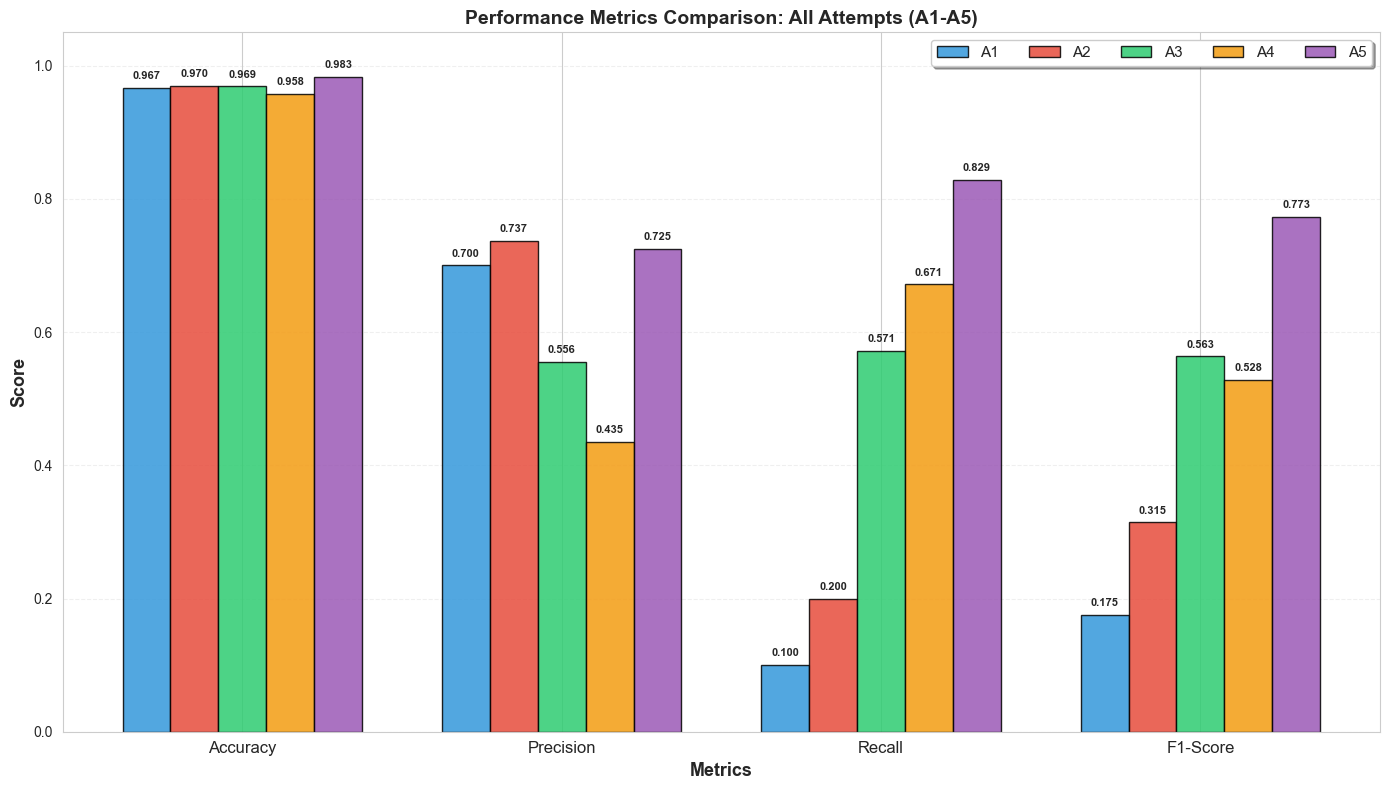

In [29]:
# All Metrics Comparison 


fig, ax = plt.subplots(figsize=(14, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
attempts = ['A1', 'A2', 'A3', 'A4', 'A5']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# A3 = Threshold tuned, no SMOTE (uses y_proba_2); A4 = LR+SMOTE with tuned threshold
data = {
    'A1': [acc_1, prec_1, rec_1, f1_1],
    'A2': [acc_2, prec_2, rec_2, f1_2],
    'A3': [acc_3_tuned, prec_3_tuned, rec_3_tuned, f1_3_tuned],
    'A4': [acc_4, prec_4, rec_4, f1_4],
    'A5': [acc_5, prec_5, rec_5, f1_5]
}

# Plot grouped bars
x = np.arange(len(metrics))
width = 0.15

for i, (attempt, color) in enumerate(zip(attempts, colors)):
    offset = (i - 2) * width
    bars = ax.bar(x + offset, data[attempt], width, 
                   label=attempt, alpha=0.85, color=color, edgecolor='black', linewidth=1)
    

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Performance Metrics Comparison: All Attempts (A1-A5)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=11, loc='upper right', ncol=5, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()



[ROC Curves Comparison]



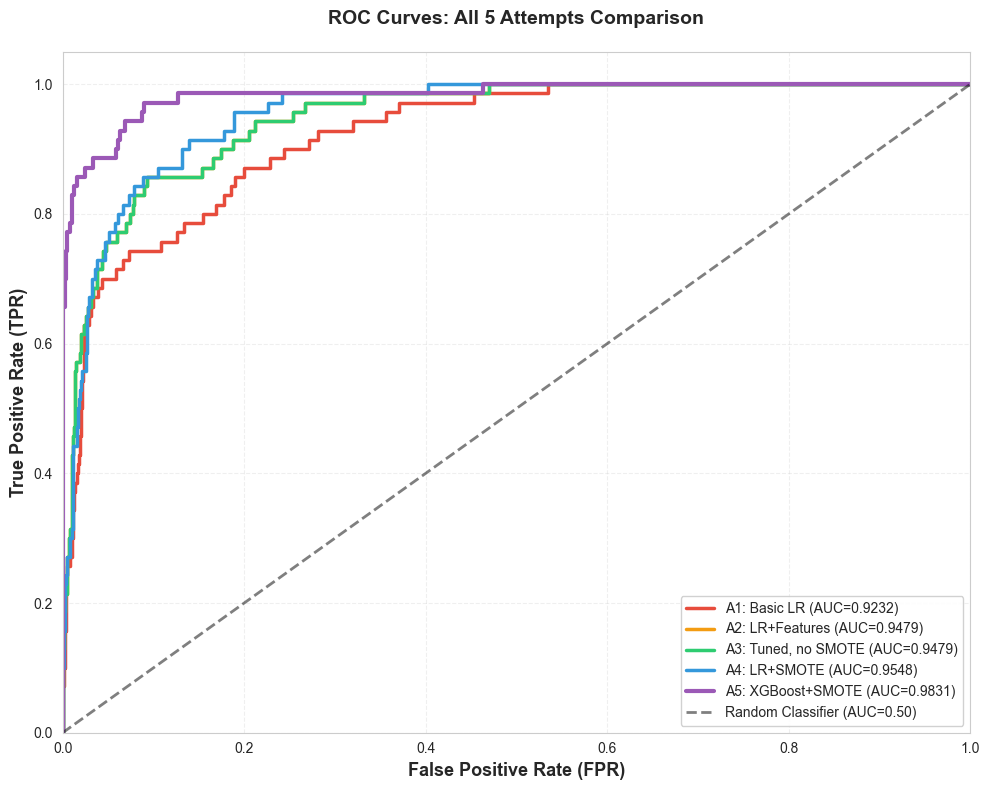

ROC-AUC Summary:
  Attempt 1 (Basic LR):        AUC = 0.9232
  Attempt 2 (LR + Features):   AUC = 0.9479  (+0.0248)
  Attempt 3 (Tuned, no SMOTE): AUC = 0.9479  (+0.0248)
  Attempt 4 (LR + SMOTE):      AUC = 0.9548  (+0.0317)
  Attempt 5 (XGBoost + SMOTE): AUC = 0.9831  (+0.0600)

  Total improvement: 0.0600 (6.50% increase)


In [30]:
# Visualization: ROC Curves for All 5 Attempts
from sklearn.metrics import roc_curve
print("\n[ROC Curves Comparison]\n")

fig, ax = plt.subplots(figsize=(10, 8))

# Calculate ROC curves for all attempts

fpr_1, tpr_1, _ = roc_curve(y_test, y_proba_1)
ax.plot(fpr_1, tpr_1, linewidth=2.5, label=f'A1: Basic LR (AUC={auc_1:.4f})', color='#e74c3c')

fpr_2, tpr_2, _ = roc_curve(y_test, y_proba_2)
ax.plot(fpr_2, tpr_2, linewidth=2.5, label=f'A2: LR+Features (AUC={auc_2:.4f})', color='#f39c12')

# Attempt 3: threshold tuned, no SMOTE (same proba as Attempt 2)
fpr_3, tpr_3, _ = roc_curve(y_test, y_proba_2)
ax.plot(fpr_3, tpr_3, linewidth=2.5, label=f'A3: Tuned, no SMOTE (AUC={auc_2:.4f})', color='#2ecc71')

# Attempt 4: LR + SMOTE (default / tuned share same ROC)
fpr_4, tpr_4, _ = roc_curve(y_test, y_proba_3)
ax.plot(fpr_4, tpr_4, linewidth=2.5, label=f'A4: LR+SMOTE (AUC={auc_3:.4f})', color='#3498db')

fpr_5, tpr_5, _ = roc_curve(y_test, y_proba_5)
ax.plot(fpr_5, tpr_5, linewidth=3, label=f'A5: XGBoost+SMOTE (AUC={auc_5:.4f})', color='#9b59b6')

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random Classifier (AUC=0.50)')

ax.set_xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves: All 5 Attempts Comparison', fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# Print summary
print("ROC-AUC Summary:")
print(f"  Attempt 1 (Basic LR):        AUC = {auc_1:.4f}")
print(f"  Attempt 2 (LR + Features):   AUC = {auc_2:.4f}  (+{(auc_2-auc_1):.4f})")
print(f"  Attempt 3 (Tuned, no SMOTE): AUC = {auc_2:.4f}  (+{(auc_2-auc_1):.4f})")
print(f"  Attempt 4 (LR + SMOTE):      AUC = {auc_3:.4f}  (+{(auc_3-auc_1):.4f})")
print(f"  Attempt 5 (XGBoost + SMOTE): AUC = {auc_5:.4f}  (+{(auc_5-auc_1):.4f})")
print(f"\n  Total improvement: {(auc_5-auc_1):.4f} ({(auc_5-auc_1)/auc_1*100:.2f}% increase)")


---
# AFeature Comparison for Attempts 4 and 5

Compare how features work different in two models.


Generating feature importance comparison visualizations...
Total features in dataset: 8


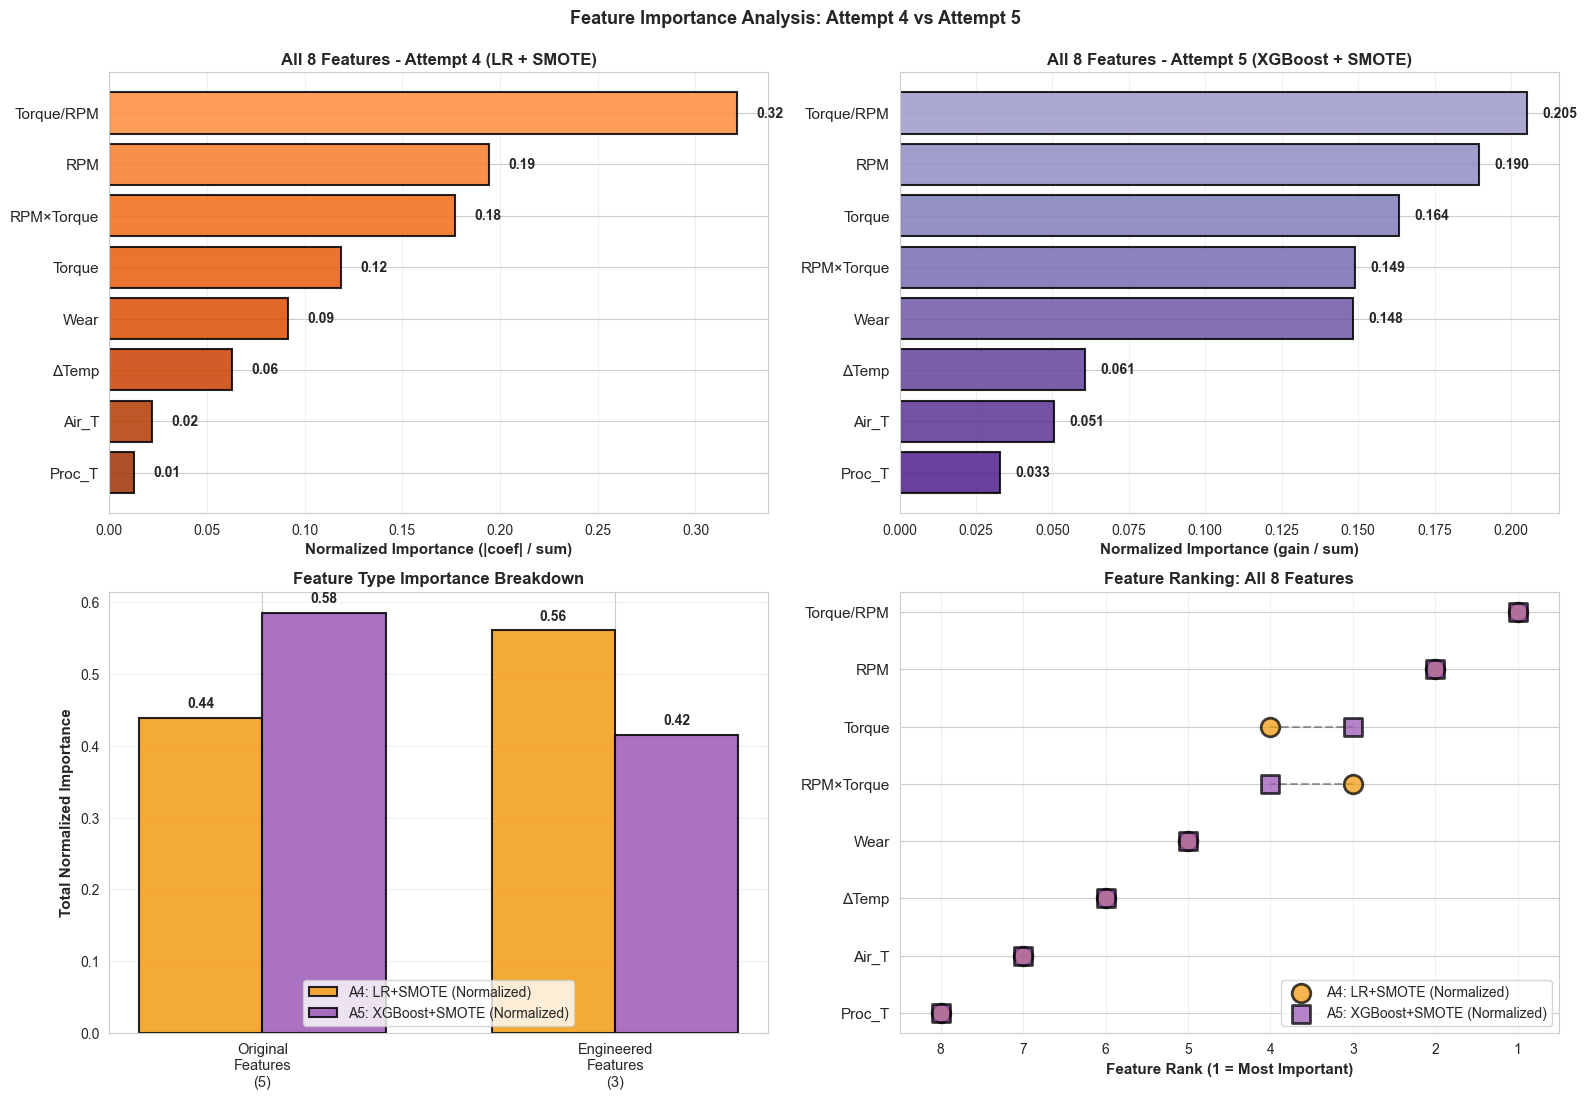


Feature importance comparison complete!
Analyzed all 8 features (5 original + 3 engineered)


In [31]:
# Visualization: Feature Importance Comparison (Attempt 4 vs 5)
print("\nGenerating feature importance comparison visualizations...")
print(f"Total features in dataset: {len(X_train_fe.columns)}")


def shorten_name(name):
    name = name.replace(' (K)', '').replace(' (rpm)', '').replace(' (Nm)', '').replace(' (min)', '')
    name = name.replace('Air temperature', 'Air_T').replace('Process temperature', 'Proc_T')
    name = name.replace('Rotational speed', 'RPM').replace('Tool wear', 'Wear')
    name = name.replace('_x_', '×').replace('_squared', '²')
    name = name.replace('Temp_Diff', 'ΔTemp').replace('Speed_Torque', 'RPM×Torque')
    name = name.replace('Torque_per_RPM', 'Torque/RPM')
    return name

feature_names = X_train_fe.columns
feature_names_short = [shorten_name(name) for name in feature_names]
n_features = len(feature_names)

fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# Logistic Regression (Attempt 4)
ax = axes[0, 0]
lr_coef_raw = np.abs(lr_smote.coef_[0])
lr_coef = lr_coef_raw / lr_coef_raw.sum()  # normalize by total importance
indices = np.argsort(lr_coef)[::-1]

bars = ax.barh(range(len(indices)), lr_coef[indices], 
               color=plt.cm.Oranges(np.linspace(0.5, 0.9, len(indices))),
               edgecolor='black', alpha=0.85, linewidth=1.5)
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_names_short[i] for i in indices], fontsize=11)
ax.set_xlabel('Normalized Importance (|coef| / sum)', fontsize=11, fontweight='bold')
ax.set_title(f'All {n_features} Features - Attempt 4 (LR + SMOTE)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for idx, bar in zip(indices, bars):
    height = bar.get_width()
    ax.text(height + 0.01, bar.get_y() + bar.get_height()/2,
            f'{height:.2f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

# XGBoost (Attempt 5)
ax = axes[0, 1]
feature_importance_raw = xgb_model.feature_importances_
feature_importance = feature_importance_raw / feature_importance_raw.sum()  # normalize by total
indices = np.argsort(feature_importance)[::-1]

bars = ax.barh(range(len(indices)), feature_importance[indices], 
               color=plt.cm.Purples(np.linspace(0.5, 0.9, len(indices))),
               edgecolor='black', alpha=0.85, linewidth=1.5)
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_names_short[i] for i in indices], fontsize=11)
ax.set_xlabel('Normalized Importance (gain / sum)', fontsize=11, fontweight='bold')
ax.set_title(f'All {n_features} Features - Attempt 5 (XGBoost + SMOTE)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for idx, bar in zip(indices, bars):
    height = bar.get_width()
    ax.text(height + 0.005, bar.get_y() + bar.get_height()/2,
            f'{height:.3f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax = axes[1, 0]


original_features = list(range(5))  # First 5
engineered_features = list(range(5, 8))  # Last 3



lr_original = lr_coef[original_features].sum()
lr_engineered = lr_coef[engineered_features].sum()

xgb_original = feature_importance[original_features].sum()
xgb_engineered = feature_importance[engineered_features].sum()

categories = ['Original\nFeatures\n(5)', 'Engineered\nFeatures\n(3)']
x_pos = np.arange(len(categories))
width = 0.35

lr_values = [lr_original, lr_engineered]
xgb_values = [xgb_original, xgb_engineered]

bars1 = ax.bar(x_pos - width/2, lr_values, width, 
               label='A4: LR+SMOTE (Normalized)', alpha=0.85, color='#f39c12', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, xgb_values, width, 
               label='A5: XGBoost+SMOTE (Normalized)', alpha=0.85, color='#9b59b6', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Total Normalized Importance', fontsize=11, fontweight='bold')
ax.set_title('Feature Type Importance Breakdown', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=10.5)
ax.legend(fontsize=10, loc='lower center')
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')


ax = axes[1, 1]

# Get rankings
lr_ranks = {}
xgb_ranks = {}
for i in range(n_features):
    lr_ranks[i] = np.where(np.argsort(lr_coef)[::-1] == i)[0][0] + 1
    xgb_ranks[i] = np.where(np.argsort(feature_importance)[::-1] == i)[0][0] + 1


xgb_order = np.argsort(feature_importance)[::-1]
all_features_list = [feature_names_short[i] for i in xgb_order]
lr_ranking = [lr_ranks[i] for i in xgb_order]
xgb_ranking = [xgb_ranks[i] for i in xgb_order]

y_pos = np.arange(len(all_features_list))

# Plot rankings
ax.scatter(lr_ranking, y_pos, s=180, color='#f39c12', alpha=0.75, 
           edgecolors='black', linewidth=2, label='A4: LR+SMOTE (Normalized)', marker='o', zorder=3)
ax.scatter(xgb_ranking, y_pos, s=180, color='#9b59b6', alpha=0.75, 
           edgecolors='black', linewidth=2, label='A5: XGBoost+SMOTE (Normalized)', marker='s', zorder=3)


for i in range(len(all_features_list)):
    ax.plot([lr_ranking[i], xgb_ranking[i]], [y_pos[i], y_pos[i]], 
            'k--', alpha=0.35, linewidth=1.5, zorder=1)

ax.set_yticks(y_pos)
ax.set_yticklabels(all_features_list, fontsize=11)
ax.set_xlabel('Feature Rank (1 = Most Important)', fontsize=11, fontweight='bold')
ax.set_title(f'Feature Ranking: All {n_features} Features', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.invert_xaxis()
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim([n_features + 0.5, 0.5])
ax.set_xticks(range(1, n_features + 1))

plt.suptitle('Feature Importance Analysis: Attempt 4 vs Attempt 5', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\nFeature importance comparison complete!")
print(f"Analyzed all {n_features} features (5 original + 3 engineered)")

---
# Final Comparison


In [33]:
# Generate final comparison table

comparison_table = pd.DataFrame({
    'Attempt': [
        'A1: Basic LR',
        'A2: LR + Features',
        'A3: Threshold Tuned',
        'A4: LR + SMOTE (Tuned)',
        'A5: XGBoost + SMOTE'
    ],
    'Accuracy': [
        f'{acc_1*100:.2f}%',
        f'{acc_2*100:.2f}%',
        f'{acc_3_tuned*100:.2f}%',
        f'{acc_4*100:.2f}%',
        f'{acc_5*100:.2f}%'
    ],
    'Precision': [
        f'{prec_1*100:.2f}%',
        f'{prec_2*100:.2f}%',
        f'{prec_3_tuned*100:.2f}%',
        f'{prec_4*100:.2f}%',
        f'{prec_5*100:.2f}%'
    ],
    'Recall': [
        f'{rec_1*100:.2f}%',
        f'{rec_2*100:.2f}%',
        f'{rec_3_tuned*100:.2f}%',
        f'{rec_4*100:.2f}%',
        f'{rec_5*100:.2f}%'
    ],
    'F1 Score': [
        f'{f1_1:.4f}',
        f'{f1_2:.4f}',
        f'{f1_3_tuned:.4f}',
        f'{f1_4:.4f}',
        f'{f1_5:.4f}'
    ],
    'AUC': [
        f'{auc_1:.4f}',
        f'{auc_2:.4f}',
        f'{roc_auc_score(y_test, y_proba_2):.4f}',
        f'{auc_4:.4f}',
        f'{auc_5:.4f}'
    ],
    'Key Change': [
        'Basic',
        'Features',
        'Threshold tuning',
        'SMOTE + Tuning',
        'SMOTE + XGBoost'
    ]
})

print(comparison_table.to_string(index=False))

               Attempt Accuracy Precision Recall F1 Score    AUC       Key Change
          A1: Basic LR   96.70%    70.00% 10.00%   0.1750 0.9232            Basic
     A2: LR + Features   96.95%    73.68% 20.00%   0.3146 0.9479         Features
   A3: Threshold Tuned   96.90%    55.56% 57.14%   0.5634 0.9479 Threshold tuning
A4: LR + SMOTE (Tuned)   95.80%    43.52% 67.14%   0.5281 0.9548   SMOTE + Tuning
   A5: XGBoost + SMOTE   98.30%    72.50% 82.86%   0.7733 0.9831  SMOTE + XGBoost
